## ITALIAN ENERGY PRICES FORECASTING 
###  Using RNN as an approach of machine learning techinques


#### Student: Luca Pirarba 

### Introduction to italian ladscape
Italy is a very particular country from a geographical point of view, different landscapes are present in a few kilometers of land, from the sea to the mountains passing through hills where the best wines are produced. Italy is not a state with a regular shape, like France, or Spain; instead, it has a very narrow shape as if it were a spine where the vertebrae are the Apennines. Two of its largest regions are Islands, with the farthest one, Sardinia, being a good 450 km from the coast of the continent. 
This particular morphology of the territory, so varied has made the development of the power grid very complicated, with unique infrastructures in Europe such as the SAPEI submarine cable that crosses the Tyrrhenian Sea and allows the exchange of energy flows from Sardinia to Lazio. 

***
![Image Alt Text](https://energycue.it/wp-content/uploads/2017/04/SAPEI-posa1-terna-Close-up-Engineering.jpg)
Source: energycue.it, SAPEI pose
***


Each European state has its own TSO, or Transmission System Operator; in Italy this task is entrusted to Terna SPA, which has a central role in the Italian electricity system. It works to ensure its proper functioning for everyone, from energy operators down to businesses and households. Terna is in charge of energy dispatching, that is, the flows of energy that after being produced, through cables must be used by end users, such as households, businesses, and activities in general. 

The energy market is divided into 3 main phases:



                                                     Generation
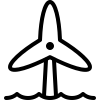

                                                    Transmission
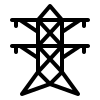 

                                                      Load 
                                                     
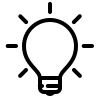 


In order to analyze, and predict price trends in the italian energy market, I decided to look at several variables, each pertaining to these 3 different "phases" of the market. 
To obtain the data, I relied on several APIs. 

- API Terna: to obtain data of generation divided by source and national aggregate demand.

- Meteostat API: to get weather data from different areas of Italy, both historical and forecast data.

- GME FTP Server: not a real API, it is a server with several directories all concerning the Italian electricity market, there are the prices of the various markets, quantities for sale, for purchase, and other measures concerning transactions in the markets.



Let's start downloading the data to populate the Storic Dataset:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import meteostat
from datetime import datetime
from time import sleep
from meteostat import Point, Daily, Hourly
from meteostat import Stations
from warnings import warn
from datetime import datetime
import ftplib
import base64,xml.dom.minidom
import xml.etree.ElementTree as ET
import numpy as np
import os
from xml.dom.minidom import Node
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

In [7]:
today = date.today()

n = 1 #NUMBER OF DAYS YOU WANT TO COME BACK WITH

try:   
    yesterday = today + timedelta(days=-n)
    yesterday = yesterday.strftime("%m/%d/%Y")
        

    #data_inizio = "21/04/2023"
    data_inizio = yesterday
    data_fine = yesterday
    print(data_inizio, data_fine)


    data = {

        'client_id': 'LucaPirarba',
        'client_secret': 'Cattolica202305',
        'grant_type': 'client_credentials',
    }

    response = requests.post('https://api.terna.it/transparency/oauth/accessToken', data = data)

    response = response.text
    response_data = response.split('"')
    token = response_data[3]
    token
    sleep(1)

    headers = {

        'accept': 'application/json',
        'authorization': 'Bearer' + ' ' + token,
    }

    params = {

        'dateFrom': data_inizio,
        'dateTo': data_fine,

    }

    response_ = requests.get('https://api.terna.it/transparency/v1.0/gettotalload', params = params, headers = headers)
    total_load = response_.text

    values = json.loads(total_load)
    values
    load = []
    dates = []

    for criteria in values['totalLoad']:

        if criteria['Bidding_Zone'] == 'Italy':

            load.append(criteria['Total_Load_MW'])

    for criteria in values['totalLoad']:

        if criteria['Bidding_Zone'] == 'Italy':

            dates.append(criteria['Date'])

    Actual_load = pd.DataFrame({'Data' : dates})
    Actual_load['Total Load MW'] = load

except:
    yesterday = today + timedelta(days=-n)
    yesterday = yesterday.strftime("%d/%m/%Y")
    data_inizio = data_fine = yesterday

    data = {

        'client_id': 'LucaPirarba',
        'client_secret': 'Cattolica_202305',
        'grant_type': 'client_credentials',
    }

    response = requests.post('https://api.terna.it/transparency/oauth/accessToken', data = data)

    response = response.text
    response_data = response.split('"')
    token = response_data[3]
    token
    sleep(1)

    headers = {

        'accept': 'application/json',
        'authorization': 'Bearer' + ' ' + token,
    }

    params = {

        'dateFrom': data_inizio,
        'dateTo': data_fine,

    }

    response_ = requests.get('https://api.terna.it/transparency/v1.0/gettotalload', params = params, headers = headers)
    total_load = response_.text

    values = json.loads(total_load)
    values
    load = []
    dates = []

    for criteria in values['totalLoad']:

        if criteria['Bidding_Zone'] == 'Italy':

            load.append(criteria['Total_Load_MW'])

    for criteria in values['totalLoad']:

        if criteria['Bidding_Zone'] == 'Italy':

            dates.append(criteria['Date'])

    Actual_load = pd.DataFrame({'Data' : dates})
    Actual_load['Total Load MW'] = load

Actual_load['Data'] = pd.to_datetime(Actual_load['Data'], utc = True, infer_datetime_format = True)

Actual_load = Actual_load.sort_values(by = 'Data', ascending = True)

Actual_load_copy = Actual_load.copy()

Actual_load_copy['Data'] = Actual_load_copy['Data'].dt.strftime('%Y-%m-%d')

unique_dates = Actual_load_copy['Data'].unique()

carico_orario = []
n_ore_in_un_giorno = []

for j in range(0, unique_dates.shape[0]):

    carico_quarti = Actual_load_copy.loc[Actual_load_copy['Data'] == unique_dates[j]].to_numpy()
    carico_quarti = carico_quarti[:, 1].astype('float64')
    
    n_quarti = len(carico_quarti)
    n_ore_in_un_giorno.append(int(n_quarti/4))
    
    for i in range(0, n_quarti, 4):
    
        media = np.mean(carico_quarti[i:i+4])
        carico_orario.append(media)
    
carico_orario = np.array(carico_orario).flatten()
carico_orario_gw = carico_orario/1000


print("Carico: ", len(carico_orario_gw))

df = pd.DataFrame({'Data' : dates})
df['Data'] = pd.to_datetime(df['Data'], utc = True, infer_datetime_format = True)
df = df.set_index('Data')
df = df.resample('60min').sum()
df = df.head(len(carico_orario_gw))

print("DF con le date : ", len(df))


sleep(2)

headers = {
    
    'accept': 'application/json',
    'authorization': 'Bearer' + ' ' + token,
}

params = {
    
    'dateFrom': data_inizio,
    'dateTo': data_fine,

}

response_ = requests.get('https://api.terna.it/transparency/v1.0/getactualgeneration', params = params, headers = headers)

actual_generation = response_.text

values = json.loads(actual_generation)


thermal = []
wind = []
hydro = []
photo = []
self_c = []
dates = []

for criteria in values['actualGeneration']:
    
    if criteria['Primary_Source'] == 'Thermal':
    
        thermal.append(criteria['Actual_Generation_GWh'])
        
for criteria in values['actualGeneration']:
    
    if criteria['Primary_Source'] == 'Wind':
    
        wind.append(criteria['Actual_Generation_GWh'])
        
for criteria in values['actualGeneration']:
    
    if criteria['Primary_Source'] == 'Hydro':
    
        hydro.append(criteria['Actual_Generation_GWh'])
        
for criteria in values['actualGeneration']:
    
    if criteria['Primary_Source'] == 'Photovoltaic':
    
        photo.append(criteria['Actual_Generation_GWh'])
        
for criteria in values['actualGeneration']:
    
    if criteria['Primary_Source'] == 'Self-consumption':
    
        self_c.append(criteria['Actual_Generation_GWh'])
        
for criteria in values['actualGeneration']:
    
        dates.append(criteria['Date'])
        
        
hydro = np.array(hydro)#[:-1]
self_c = np.array(self_c)#[:-1]
thermal = np.array(thermal)#[:-1]
wind = np.array(wind)#[:-1]
photo = np.array(photo)#[:-1]

print("Production sources df: ", len(hydro))

df['Idro GWh'] = hydro[::-1]
df['Fotovoltaico GWh'] = photo[::-1]
df['Autoconsumo GWh'] = self_c[::-1]
df['Termico GWh'] = thermal[::-1]
df['Wind GWh'] = wind[::-1]
df['Carico GW'] = carico_orario_gw


df

05/15/2023 05/15/2023
Carico:  24
DF con le date :  24
Production sources df:  24


Idro GWh Fotovoltaico GWh Autoconsumo GWh  \
Data                                                                  
2023-05-15 00:00:00+00:00     4.71                0           1.688   
2023-05-15 01:00:00+00:00     4.21                0            1.69   
2023-05-15 02:00:00+00:00     4.13                0           1.682   
2023-05-15 03:00:00+00:00     4.17                0           1.717   
2023-05-15 04:00:00+00:00     4.15                0           1.805   
2023-05-15 05:00:00+00:00     4.42                0           1.873   
2023-05-15 06:00:00+00:00     5.75             0.26           2.473   
2023-05-15 07:00:00+00:00     8.41             1.65           3.231   
2023-05-15 08:00:00+00:00     8.51             3.75            3.85   
2023-05-15 09:00:00+00:00     7.41             5.71           4.575   
2023-05-15 10:00:00+00:00     5.85             6.35           4.491   
2023-05-15 11:00:00+00:00     5.64             7.41           4.685   
2023-05-15 12:00:00+00:00     5.56             7.31           4.583   
2023-05-15 13:00:00+00:00     4.68             7.89           4.692   
2023-05-15 14:00:00+00:00     4.67             7.96           4.635   
2023-05-15 15:00:00+00:00     4.93             6.97           4.413   
2023-05-15 16:00:00+00:00      5.2             5.45           4.072   
2023-05-15 17:00:00+00:00     5.36             4.52           4.177   
2023-05-15 18:00:00+00:00      5.7             2.75           4.096   
2023-05-15 19:00:00+00:00     6.88             0.85           4.024   
2023-05-15 20:00:00+00:00     8.34             0.04           4.097   
2023-05-15 21:00:00+00:00     8.44                0           4.135   
2023-05-15 22:00:00+00:00      7.3                0           3.885   
2023-05-15 23:00:00+00:00     4.96                0           3.443   

                          Termico GWh Wind GWh  Carico GW  \
Data                                                        
2023-05-15 00:00:00+00:00        8.44     1.79  22.790499   
2023-05-15 01:00:00+00:00        7.99     1.63  21.522751   
2023-05-15 02:00:00+00:00        7.74     1.32  21.042249   
2023-05-15 03:00:00+00:00         8.2     0.93  21.017250   
2023-05-15 04:00:00+00:00        8.61     0.98  21.462500   
2023-05-15 05:00:00+00:00        9.68     1.29  23.054500   
2023-05-15 06:00:00+00:00       12.02     1.51  27.933500   
2023-05-15 07:00:00+00:00       13.52      1.3  34.022750   
2023-05-15 08:00:00+00:00       13.82      1.3  38.678500   
2023-05-15 09:00:00+00:00        13.6     1.73  40.317000   
2023-05-15 10:00:00+00:00       12.87     1.89  39.148500   
2023-05-15 11:00:00+00:00       12.32     2.02  39.645500   
2023-05-15 12:00:00+00:00       11.46     2.14  37.880250   
2023-05-15 13:00:00+00:00       11.05     2.57  37.859250   
2023-05-15 14:00:00+00:00       10.69      2.7  38.070000   
2023-05-15 15:00:00+00:00       11.33      2.7  37.782750   
2023-05-15 16:00:00+00:00       11.72     3.44  37.073500   
2023-05-15 17:00:00+00:00       12.68     4.19  37.664000   
2023-05-15 18:00:00+00:00       13.79     4.84  37.422251   
2023-05-15 19:00:00+00:00       14.54     4.75  37.952500   
2023-05-15 20:00:00+00:00       14.89     4.53  38.529000   
2023-05-15 21:00:00+00:00       14.58     4.09  37.685000   
2023-05-15 22:00:00+00:00       13.28     3.85  34.503250   
2023-05-15 23:00:00+00:00       11.49     3.89  30.988500   

                          Scambio Programmato Netto Francia MW  \
Data                                                             
2023-05-15 00:00:00+00:00                                 2886   
2023-05-15 01:00:00+00:00                                 3049   
2023-05-15 02:00:00+00:00                                 3113   
2023-05-15 03:00:00+00:00                               2933.7   
2023-05-15 04:00:00+00:00                                 2990   
2023-05-15 05:00:00+00:00                                 3011   
2023-05-15 06:00:00+00:00                                 3005  

This code will run automatically every day, to download the final data from the day before, doing so will populate the dataset.

Terna provides us in this case with the generation data divided by source, in GWh. Demand data, and transit data with the two neighboring countries with which we trade the most energy, France and Switzerland. At this point we consider only the first 5 columns of the dataset and analyze the generation data. 

## Generation
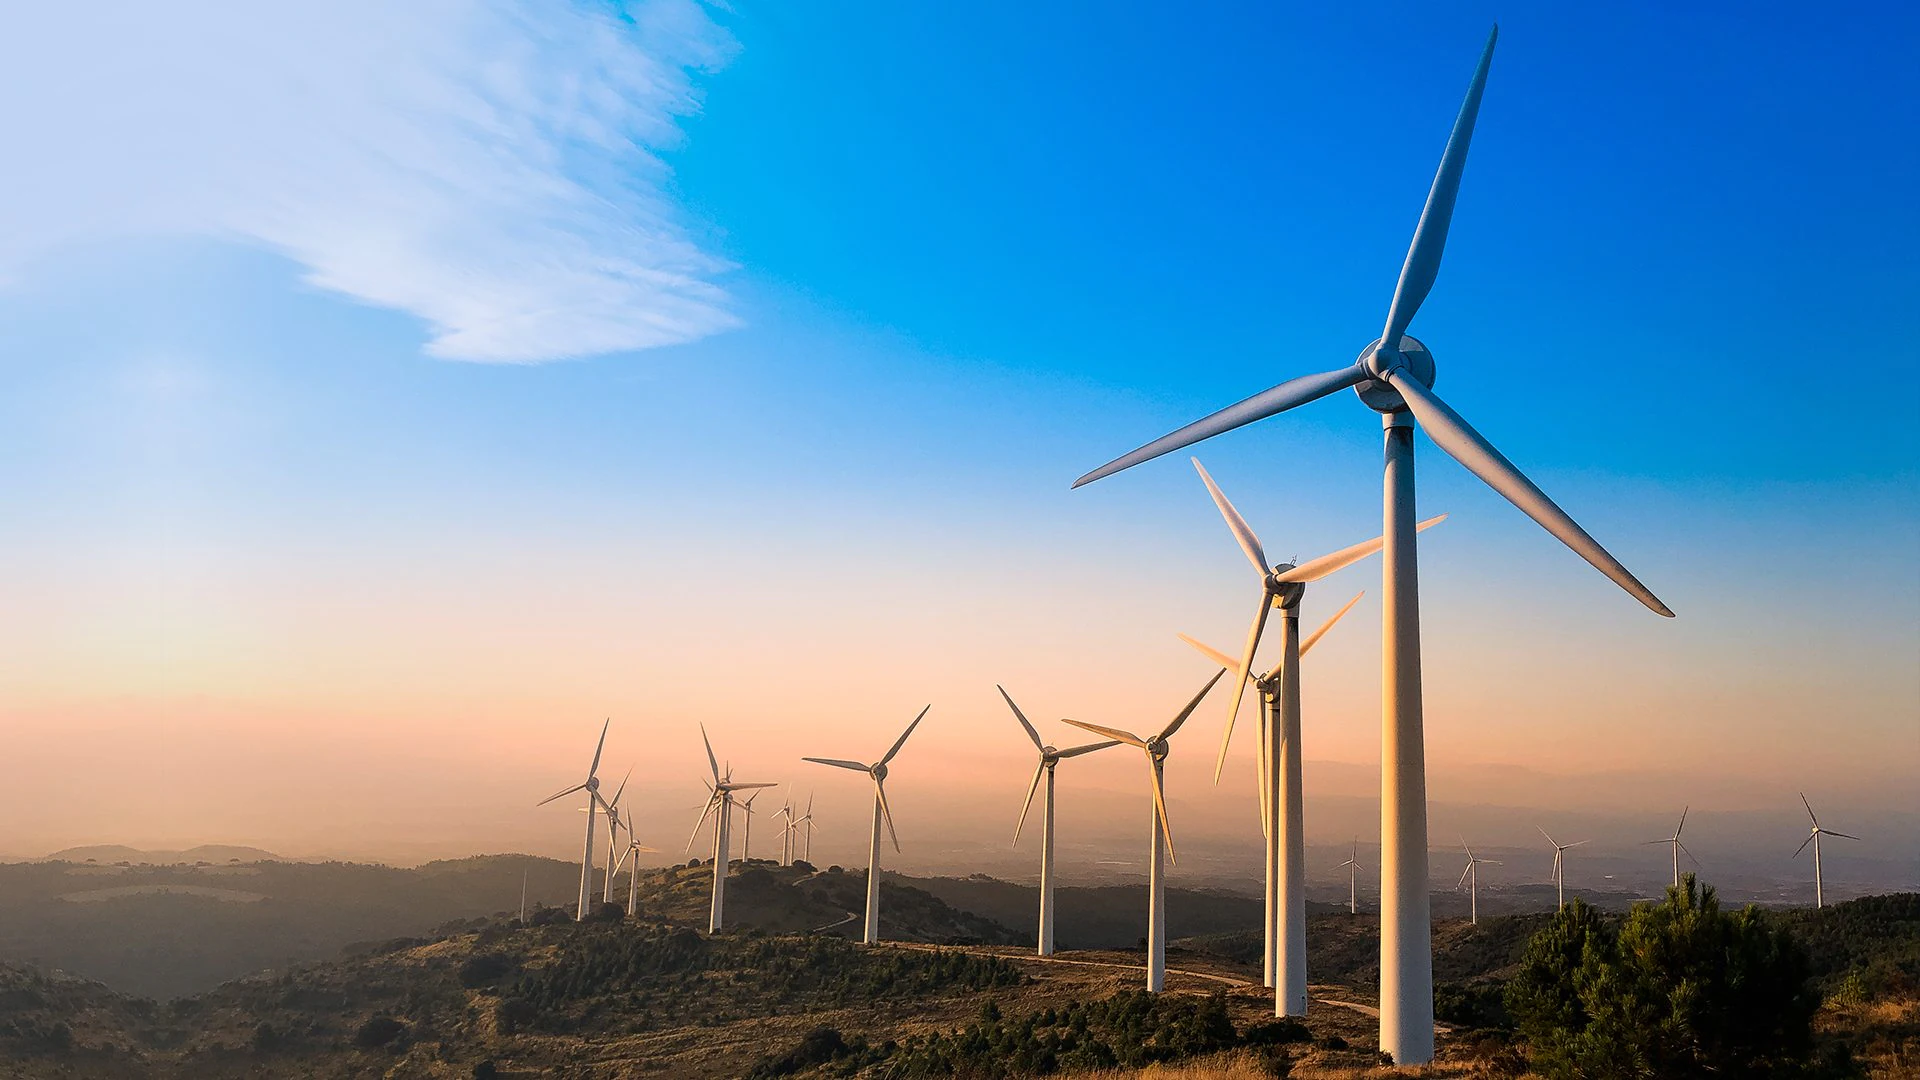

In Italy, the total domestic production of electricity is divided into various sources such as:
- Thermal
- Wind
- Photovoltaic
- Geothermal
- Self-consumption
- Hydro

Production units are distributed all over Italy, but we can identify areas where some sources of production are prevalent, just look at the map below, although production from thermal sources is well located all over Italy, production from photovoltaic is predominantly in northern Italy and in the south; Hydro is predomitating in the Northen italy, while also in the south particularly Puglia, Calabria and Sardinia, there are important wind-powered plants.  


![Example Image](Mappa_prod.png)
Source: energy-charts.info/map

In [2]:
df = pd.read_excel("/Users/antonioluca/Library/CloudStorage/GoogleDrive-lucapirarba@gmail.com/Il mio Drive/CODICI/Storico.xlsx")
df = df.set_index("Data")
df_prod = df.iloc[:, :5].tail(10*24)
df_prod

Idro GWh  Fotovoltaico GWh  Autoconsumo GWh  Termico GWh  \
Data                                                                            
2023-06-01 00:00:00      1.53              0.00            2.284        11.41   
2023-06-01 01:00:00      1.43              0.00            2.253        10.74   
2023-06-01 02:00:00      1.21              0.00            2.171        10.54   
2023-06-01 03:00:00      1.21              0.00            2.137        10.63   
2023-06-01 04:00:00      1.23              0.00            2.232        10.89   
...                       ...               ...              ...          ...   
2023-06-10 19:00:00      9.45              1.21            2.523        12.38   
2023-06-10 20:00:00      9.56              0.14            2.394        12.79   
2023-06-10 21:00:00      9.29              0.00            2.385        11.86   
2023-06-10 22:00:00      8.38              0.00            2.281        11.16   
2023-06-10 23:00:00      7.01              0.00            2.144        11.06   

                     Wind GWh  
Data                           
2023-06-01 00:00:00      1.62  
2023-06-01 01:00:00      1.41  
2023-06-01 02:00:00      1.36  
2023-06-01 03:00:00      1.13  
2023-06-01 04:00:00      0.88  
...                       ...  
2023-06-10 19:00:00      0.54  
2023-06-10 20:00:00      0.64  
2023-06-10 21:00:00      0.64  
2023-06-10 22:00:00      0.59  
2023-06-10 23:00:00      0.58  

[240 rows x 5 columns]

Let's now plot, with  a simple line scatterplot and a pie plot, the trend of the production mix in the past 10 days. we can see that the most producted energy is by "Thermal" source, so by Coal, Natural gas, and Oil with about 46% of share.

In [19]:
import plotly.graph_objects as go
import plotly.io as pio

colors = ['#FF4136', '#FF851B', '#FFDC00', 
          '#2ECC40', '#0074D9', '#B10DC9', 
          '#85144b', '#F012BE', '#39CCCC', 
          '#3D9970']

# Set the dark theme
pio.templates.default = "plotly_white"
stackgroup = "group1"
# Stacked Area Plot
fig = go.Figure()
for column, color in zip(df_prod.columns, colors):
    fig.add_trace(go.Scatter(x=df_prod.index, y=df_prod[column],
                             mode='lines', stackgroup=stackgroup, name=column,
                             fill='tonexty', line=dict(color=color)))
fig.update_layout(xaxis=dict(title='Date'), yaxis=dict(title='Energy (GWh)'),
                     title={
        'text': 'Power Generation Piechart 10 days',
        'x': 0.5,
        'y': 0.9
    })
#fig.show()


fig = go.Figure()
# Pie chart
fig.add_trace(go.Pie(labels=df_prod.index, values=df_prod.values))


fig = go.Figure()
fig.add_trace(go.Pie(
    labels=df_prod.sum().index,
    values=df_prod.sum().values,
    marker=dict(colors=colors),
    hoverinfo='label+value',
    textfont=dict(size=12),
    hole=0.72,
    sort=False
))

# Update the layout
fig.update_layout(
    title={
        'text': 'Power Generation Piechart 10 days',
        'x': 0.5,
        'y': 0.9
    }
)


# Show the plot
#fig.show()

![Example Image](newplot3.png)
![Example Image](newplot-4.png)

## Transmission

In [ ]:
headers = {
    
    'accept': 'application/json',
    'authorization': 'Bearer' + ' ' + token,
}

params = {
    
    'dateFrom': data_inizio,
    'dateTo': data_fine,

}

response_ = requests.get('https://api.terna.it/transparency/v1.0/getscheduledforeignexchange', params = params, headers = headers)

scheduled_ex = response_.text

values = json.loads(scheduled_ex)

scheduled_ex_france = []
scheduled_ex_swiss = []

for criteria in values['scheduledForeignExchange']:
    
    if criteria['Country'] == 'France':
    
        scheduled_ex_france.append(criteria['Scheduled_Foreign_Exchange_MW'])
    
for criteria in values['scheduledForeignExchange']:
    
    if criteria['Country'] == 'Switzerland':
        
        scheduled_ex_swiss.append(criteria['Scheduled_Foreign_Exchange_MW'])
        
        
df['Scambio Programmato Netto Francia MW'] = scheduled_ex_france
df['Scambio Programmato Netto Svizzera MW'] = scheduled_ex_swiss



sleep(2)

headers = {
    
    'accept': 'application/json',
    'authorization': 'Bearer' + ' ' + token,
}

params = {
    
    'dateFrom': data_inizio,
    'dateTo': data_fine,

}

response_ = requests.get('https://api.terna.it/transparency/v1.0/getphysicalforeignflow', params = params, headers = headers)

prog_ex = response_.text

values = json.loads(prog_ex)


prog_ex_france = []
prog_ex_swiss = []

for criteria in values['physicalForeignFlow']:
    
    if criteria['Country'] == 'France':
    
        prog_ex_france.append(criteria['Physical_Foreign_Flow_MW'])
    
for criteria in values['physicalForeignFlow']:
    
    if criteria['Country'] == 'Switzerland':
        
        prog_ex_swiss.append(criteria['Physical_Foreign_Flow_MW'])
        
df['Scambio Fisico Netto Francia MW'] = prog_ex_france
df['Scambio Fisico Netto Svizzera MW'] = prog_ex_swiss

In [20]:
selected_df = df.iloc[:, 6:10]
df_exc = selected_df.tail(10*24)
df_exc

# Create the scatter line plot
fig = go.Figure()

# Add scatter traces for each column
for column in df_exc.columns:
    fig.add_trace(go.Scatter(x=df_exc.index, y=df_exc[column], mode='lines', name=f"{column}h"))

# Update the layout
fig.update_layout(
    title='Scatter Line Plot',
    xaxis=dict(title='Date'),
    yaxis=dict(title='MWh')
)

# Show the plot
#fig.show()

![Example Image](newplot-5.png)

## Total Load

In [5]:
dfgen = df["Carico GW"].tail(24*10)
dfprod = df["Idro GWh"]+df["Fotovoltaico GWh"]+df["Autoconsumo GWh"]+df["Termico GWh"]+df["Wind GWh"]
dfprod = dfprod.tail(24*10)
# Create the scatter line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=dfgen.index, y=dfgen, mode='lines', name="Load GWh"))
fig.add_trace(go.Scatter(x=dfprod.index, y=dfprod, mode='lines', name="Generation GWh"))

fig.update_layout(
    title='Load Line Plot',
    xaxis=dict(title='Date'),
    yaxis=dict(title='GWh'))

fig.show()

![Example Image](newplot-11.png)

From the graph above we can see that the demand curve pattern follows a daily or weekly seasonality. This means that demand varies predictably by day of the week or time of day, showing a recurring pattern over time.

## Italian Market power prices 

The Italian electricity market, contrary to the stock market of the Italian stock exchange, is not a continuous trading market but an auction market, which means that every day in different market sessions the price is decided by uploading buy/sell bids with price and quantity in object to the "IPEX" portal. Prices are nothing but the intersection of supply and demand and a different price is formed for each of the 24 hours of the day traded, for each market session, for each zone.
The market sessions are:

- MGP ( Mercato del giorno prima)
- MI1 ( Mercato infragiornaliero 1)
- MI2 ( Mercato infragiornaliero 2)
- MI3 ( Mercato infragiornaliero 3, Last market in which it is possible to trade only from hour 13 to 24 of the day in question).

Below is a small diagram made by me to visualize market times and sessions, in green the opening time of the market, in red the closing time with consequent publication of the outcomes.
***
![Image Alt Text](Market_hours.png)
***
Earlier we talked about price formation happening "per zone" this assumes that there are as many different prices as zones we can find in Italy, in fact the GME splits Italy into 7 different zones:

- CALA
- CNOR
- CSUD
- NORD
- SARD
- SICI
- SUD 

Below is the GME map with the different zones:
***
![Image Alt Text](Italy_zones.png)
***

National Aggregate Prices "MGP", "MI1,2,3" are given by the sum of prices weighted by the volumes in each zone.

Each zone has its own price, and this can depend on many drivers, only by reasoning we can think that the price certainly depends on the demand and supply of energy in that particular zone, the supply in turn will depend on what? Certainly on production, not only on the quantity produced, but also on the price that producers can afford to offer. It is clear from the outset that renewable energy impants such as wind farms or photovoltaic plants can afford to sell the energy produced at lower prices, and we can well understand that these offers will be the first to be accepted, although under the marginal pricing system they will all be accepted at the price of the last accepted offer,at the highest possible price, which "trivially" will be that offered by a thermal power plant, which carries with it the cost of the raw material, gas or coal it may be, and is therefore very much linked to the latter. 
It is easy to think, therefore, that the price of an area depends so much on whether there is a large presence of renewable source plants in that area. We will see later whether and how on days and in areas that can rely on a lot of renewable energy the price varies in comparison to the price formed in an area, such as the CNOR where there are predominantly thermal generation plants. 


As mentioned above, the GME does not provide an API for downloading data, so we have to use access to their FPT server, which is available with a simple registration. 


In this project, I will try to make a forecast of the PUN and intraday market prices, which are formed in the various markets. 

In doing the forecast we have to keep in mind that we need the forecasts of the day after the market day: so if we are on May 19 we are forecasting the price of the 20th. Being in the present day on May 19, however, we have no demand nor projection information so we have to: 
Make the forecast of the 19th and 20th for production and demand, have the weather data for both days. 
With this data we make the price forecast of the 20th.

In [ ]:
mercati = ["MGP","MI-A1","MI-A2","MI-A3"]
n = 1
for mercato in mercati:
    try:
        data_flusso = (datetime.now() + timedelta(days = n)).strftime('%Y%m%d')
        datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')

        #### MGP ####

        filename = data_flusso + f'{mercato}Prezzi.xml'

        ftp_server = ftplib.FTP("download.mercatoelettrico.org", "LUCAPIRARBA", "CATTOLICA202305")
        ftp_server.cwd(f'/MercatiElettrici/{mercato}_Prezzi')


        ftp_server.encoding = "utf-8"

        with open(filename, "wb") as file:

            ftp_server.retrbinary(f"RETR {filename}", file.write)
        file = open(filename, "r")
        data = file.read()
        doc = xml.dom.minidom.parseString(data)
        
        if mercato == "MGP":
            cols = ["PUN","CALA", "CNOR", "CSUD", "NORD", "SARD", "SICI", "SUD"]
        else:
            cols = ["NAT","CALA", "CNOR", "CSUD", "NORD", "SARD", "SICI", "SUD"]
            
        Prezzi = pd.DataFrame()

        for j in range(0, len(cols)):

            xml_data = []
            i = 0

            for topic in doc.getElementsByTagName('Prezzi'):

                title = doc.getElementsByTagName(cols[j])[i].firstChild.nodeValue

                xml_data.append(title)

                i += 1

            Prezzi[cols[j]] = xml_data
            Prezzi[cols[j]] = np.round((Prezzi[cols[j]].replace('\.','', regex=True).replace(',','.', regex=True).astype(float)), 2)

        n_ore = Prezzi.shape[0]

        Prezzi['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(Prezzi), freq= "h")
        Prezzi = Prezzi.set_index('Data')
        
        #CICLO PER CAMBIARE IL NOME ALLE COLONNE COSì DA DIFFERENZIARE I MERCATI 
        try:
            new_cols = {}
            for col in Prezzi.columns:
                new_cols[col] = col + f'_{mercato[4]}'
            Prezzi = Prezzi.rename(columns=new_cols)
        except:
            None
        
        df_storico = pd.read_excel("Storico.xlsx")
        df_storico = df_storico.set_index('Data')

        if mercato == mercati[0]:
            df_storico = pd.concat([df_storico, Prezzi], axis=0)
        else:
            df_storico.update(Prezzi)
            
        df_storico.to_excel("Storico.xlsx", index = True)
        print(f" {mercato} era presente nell' FTP e l'ho caricato in Storico.xlsx")
        

    except:
        print(f" {mercato} non ancora nell' FTP")

In [6]:
dfprices = df.iloc[:,109:141]
dfprices.tail(2)

PUN    CALA   CNOR    CSUD   NORD    SARD    SICI  \
Data                                                                       
2023-06-10 22:00:00  103.6  118.00  95.00  118.00  95.00  118.00  118.00   
2023-06-10 23:00:00   96.0   98.57  94.48   98.57  94.48   98.57   98.57   

                        SUD  NAT_1  CALA_1  ...  SICI_2  SUD_2  NAT_3  CALA_3  \
Data                                        ...                                 
2023-06-10 22:00:00  118.00  91.44   98.00  ...    90.0   90.0   90.0    90.0   
2023-06-10 23:00:00   98.57  89.48   89.99  ...    91.6   91.6   91.1    91.1   

                     CNOR_3  CSUD_3  NORD_3  SARD_3  SICI_3  SUD_3  
Data                                                                
2023-06-10 22:00:00    90.0    90.0    90.0    90.0    90.0   90.0  
2023-06-10 23:00:00    91.1    91.1    91.1    91.1    91.1   91.1  

[2 rows x 32 columns]

In [ ]:
dfpun = dfprices["PUN"].tail(24*10)
dfmi1 = dfprices["NAT_1"].tail(24*10)
dfmi2 = dfprices["NAT_2"].tail(24*10)
dfmi3 = dfprices["NAT_3"].tail(24*10)
# Create the scatter line plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfpun.index, y=dfpun, mode='lines', name="PUN"))
fig.add_trace(go.Scatter(x=dfmi1.index, y=dfmi1, mode='lines', name="MI1"))
fig.add_trace(go.Scatter(x=dfmi2.index, y=dfmi2, mode='lines', name="MI2"))
fig.add_trace(go.Scatter(x=dfmi3.index, y=dfmi3, mode='lines', name="MI3"))

fig.update_layout(
    title='Italian power prices last 10 days',
    xaxis=dict(title='Date'),
    yaxis=dict(title='€/MWh'))

fig.show()

![Example Image](newplot-5.png)

## FORECASTING PRODUCTION AND DEMAND

In order to forecast prices in the Italian energy market, I must first forecast electricity supply and demand. Demand does not depend too much on uncontrollable events, on the other hand it is very seasonal, each month has its own peculiarity, we know that in the summer months we have the peak demand because of air conditioning that allows us to cool the rooms. 

We know that on holidays there is little demand compared to weekdays where the activities, the beating heart of italy, the engine, is at full throttle. we know that demand has a well-defined curve that consists of two shoulders, and a peak.


Below is a graph that in my opinion that helps us better understand the demand curve, a boxplot graph where each boxplot represents one hour, from the whole graph we can understand the demand curve, the median for each hour, and the 25th and 75th quartile values. 

To do all this I create artificial variables to be inserted into the dataset, namely the hour, the day of the week, the quarter, the month, the year, and the day of the year. 

In [8]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour+1
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df

df1 = create_features(df)



# Define the colors
colors = ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9', '#B10DC9', '#85144b', '#F012BE', '#39CCCC', '#3D9970']

# Create the box plot
fig = go.Figure()

# Add the box trace
fig.add_trace(go.Box(
    y=df1['Carico GW'],
    x = df1["hour"],
    name='Box Plot',
    marker=dict(
        color=colors[3],
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2
        )
    ),
    boxmean='sd'
))

# Update the layout
fig.update_layout(
    title='Load Box Plot',
    yaxis=dict(title='Load GWh'),
    xaxis=dict(title='Hour'),
    showlegend=False,
    boxgap=0.1,  
    boxgroupgap=0.2  
)



# Show the plot
fig.show()

![Example Image](newplot-7.png)

Electricity supply, on the other hand, depends on the production of electricity, the generative mix from hour to hour each day in each of the 7 zones. In order to make inference on prices we have to predict the level of the various generative sources, which in turn depends on the availability of raw material, i.e., gas for thermal generation plants, sun for photovoltaic plants, wind for wind etc. 

The levels of the generative mix are then dictated by availability, and since, as we have said the bids accepted first are those from RES plants, because the feedstock is cheaper or zero cost, it is easy to understand that the more expensive plants, such as thermal plants go to fill that gap between supply and demand from renewables. 

So if all production from RES is tapped first and then production from thermal is called in to make up for it, we have to first make a forecast of the amount generated from RES(photovoltaic, hydro, geothermal and wind), and then go back to that from thermal.To test this reasoning I use a very simple correlation analysis, and a multivariate regression analysis. 

To do such an analysis I decide to take into account not the absolute values of production but rather the percentage values of the individual source out of the total demand. 

In [9]:
dfmay = df1[df1['month'] == 5]
dfmay = dfmay.iloc[:, :6]
dfmay

dfperc= pd.DataFrame()
for column in dfmay:
    dfperc[column] = df[column] / df["Carico GW"]
dfperc = dfperc.iloc[: , :5]

dfperc

Idro GWh  Fotovoltaico GWh  Autoconsumo GWh  Termico GWh  \
Data                                                                            
2022-01-01 00:00:00  0.118375          0.000000         0.067415     0.459230   
2022-01-01 01:00:00  0.104043          0.000000         0.068862     0.453203   
2022-01-01 02:00:00  0.100814          0.000000         0.073617     0.451551   
2022-01-01 03:00:00  0.099146          0.000000         0.073715     0.454585   
2022-01-01 04:00:00  0.103135          0.000000         0.074696     0.434494   
...                       ...               ...              ...          ...   
2023-06-10 19:00:00  0.293784          0.037617         0.078436     0.384872   
2023-06-10 20:00:00  0.303006          0.004437         0.075878     0.405382   
2023-06-10 21:00:00  0.297826          0.000000         0.076460     0.380217   
2023-06-10 22:00:00  0.284051          0.000000         0.077317     0.378283   
2023-06-10 23:00:00  0.254142          0.000000         0.077729     0.400972   

                     Wind GWh  
Data                           
2022-01-01 00:00:00  0.079337  
2022-01-01 01:00:00  0.089494  
2022-01-01 02:00:00  0.100345  
2022-01-01 03:00:00  0.110548  
2022-01-01 04:00:00  0.120494  
...                       ...  
2023-06-10 19:00:00  0.016788  
2023-06-10 20:00:00  0.020285  
2023-06-10 21:00:00  0.020518  
2023-06-10 22:00:00  0.019999  
2023-06-10 23:00:00  0.021027  

[12574 rows x 5 columns]

Most Important Variables:
3         Termico GWh
1    Fotovoltaico GWh
2     Autoconsumo GWh
4            Wind GWh
0            Idro GWh
Name: Variable, dtype: object


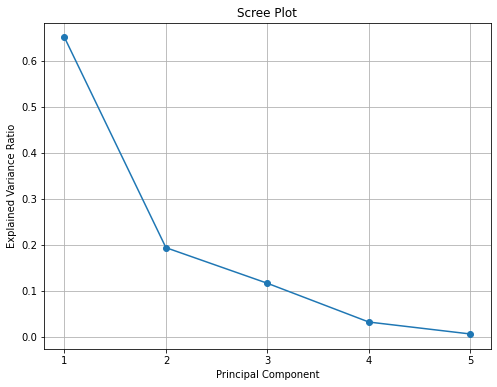

____________________________________________________________________________________________

                            Multivariate Regression for Thermal Prod 
____________________________________________________________________________________________

                            OLS Regression Results                            
Dep. Variable:            Termico GWh   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     5829.
Date:                Sun, 11 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:47:25   Log-Likelihood:                 16265.
No. Observations:               12574   AIC:                        -3.252e+04
Df Residuals:                   12569   BIC:                        -3.248e+04
Df Model:                           4                                         
Covariance Type:            non

In [10]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt



corr_matrix = dfperc.corr().round(2)

# Correlation heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    colorscale='Viridis',
    showscale=True,
)


fig.update_layout(
    title='Correlation Matrix',
    xaxis=dict(title='Features'),
    yaxis=dict(title='Features'),
)

fig.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfperc)

loadings = pca.components_[0]
loadings_df = pd.DataFrame({'Variable': dfperc.columns, 'Loading': loadings})
loadings_df['Abs_Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values('Abs_Loading', ascending=False)
most_important_vars = loadings_df.head()['Variable']
print("Most Important Variables:")
print(most_important_vars)


pca = PCA(n_components=len(dfperc.columns))  # Retain all components


pca_result = pca.fit_transform(dfperc)


explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()


import statsmodels.api as sm
print("____________________________________________________________________________________________\n")
print("                           ","\033[1;34m" + "Multivariate Regression for Thermal Prod" + " ""\033[0m")
print("____________________________________________________________________________________________\n")

X = dfperc[dfperc.columns.difference(['Termico GWh'])]
y = dfperc["Termico GWh"]

X = sm.add_constant(X)

model = sm.OLS(y, X)


results = model.fit()


print(results.summary())

![Example Image](newplot-8.png)

The analyses confirm this behavior, thermal comes in to cover that part of demand not met by RES. 
I will try to predict generation by source using only the generation data itself within the model along with the categorical variables of hour,day, month, year, and day of the week. 


## LSTM for predicting Generation and Load

2023-06-11 14:47:46.248057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


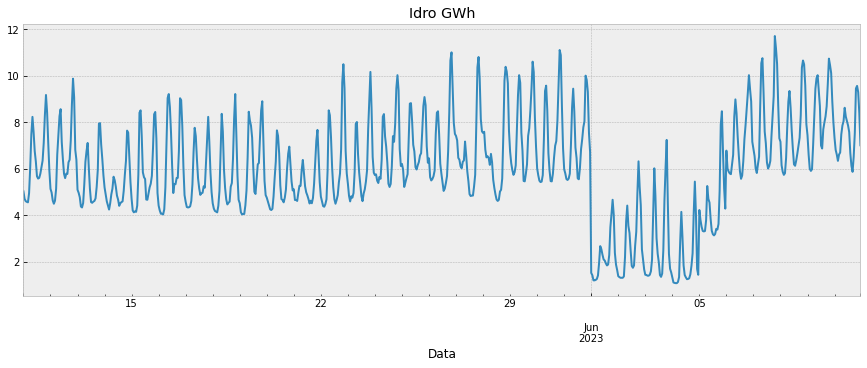

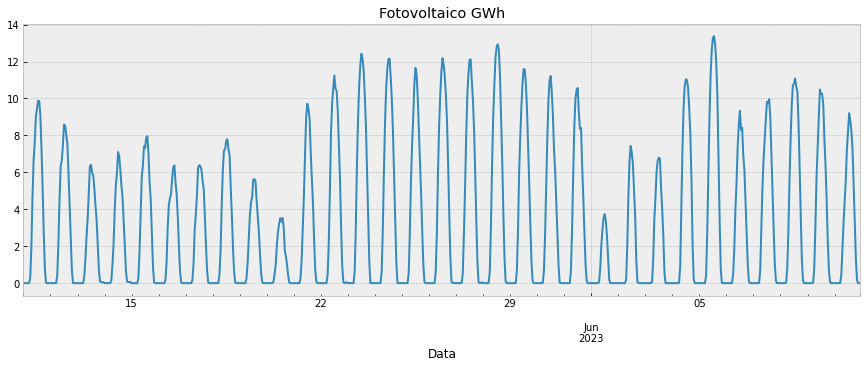

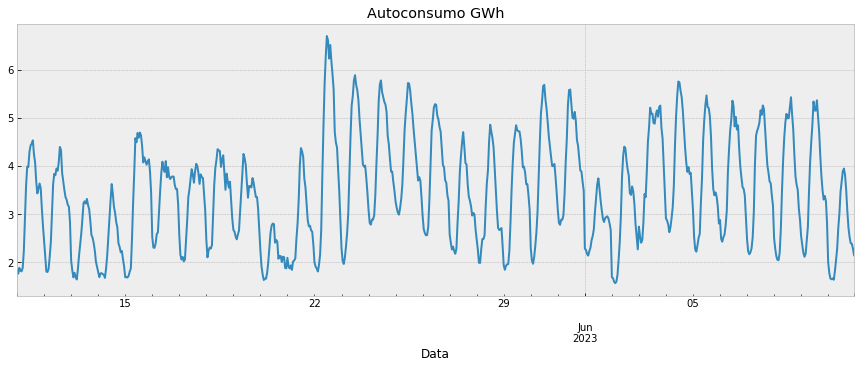

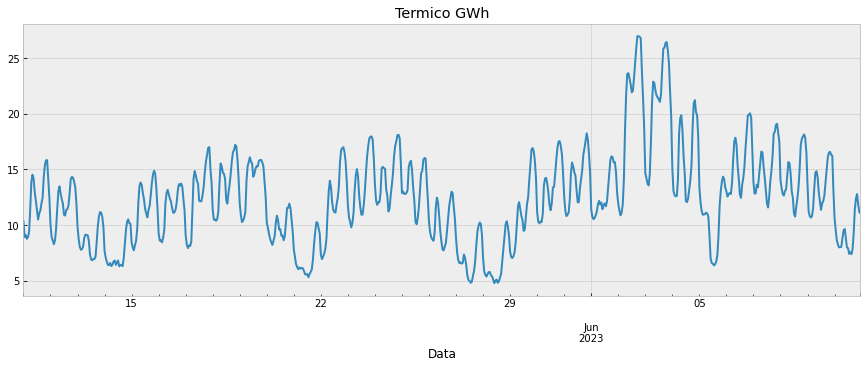

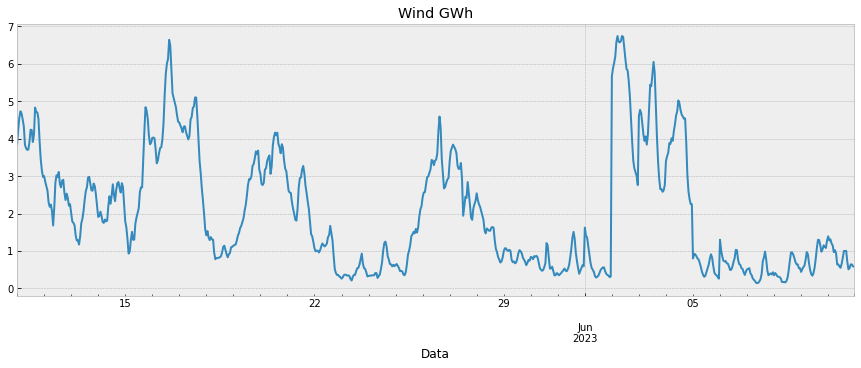

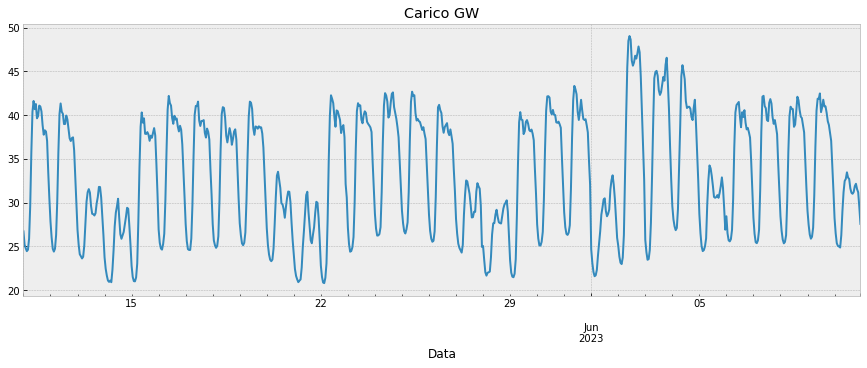

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use("bmh")
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.decomposition import PCA

sources = ['Idro GWh', 'Fotovoltaico GWh', 'Autoconsumo GWh', 'Termico GWh',
       'Wind GWh', 'Carico GW']
df1 = df.iloc[: , :6]

for source in sources:
    df1.iloc[-744:][source].plot(figsize = (15, 5))
    plt.title(source)
    plt.show()

## LSTM MODEL DEFINITION
I define the model function that I am going to apply for each production source, use a sliding window with a time step of 24, scale the data with a MinMaxScaler, train the model, and use it to make an out-of-sample prediction. 

That's all the model is:

    model = Sequential([

        Input(shape = (imgY, imgZ)), 
        LSTM(64, return_sequences = True),
        LSTM(32, return_sequences = True),
        Flatten(),
        Dense(126, activation = 'relu'),
        Dense(n_test)

    ])
    

NN models take tensors as input, so I create a 3-dimensional array. 
I use this model because it is very good for the prediction of Time Series, but I would like to delve even more into the whole topic of tune of hyperparameters, maybe through a gridsearch, how to better use and combine the various layers, I hope in the near future to be able to master it. 


In [305]:
#### MY FORECAST LSTM FUNCTION ###
def forecast(df, source, n_epochs):
    
    print("____________________________________________________________________________________________\n")
    print("                                          ","\033[1;34m" + source +"\033[0m")
    print("____________________________________________________________________________________________\n")
    
    dataset_size = np.array(df).shape[0]
    n_time_step = 24 # passo temporale
    n_test = 24

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size-n_test)])
    scaler_y.fit(y[:(dataset_size-n_test)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset = np.concatenate((X, y), axis = 1)
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, dataset_size - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train, y_train = np.array(X), np.array(y)

    X = []
    y = []

    for i in range(dataset_size - n_test - n_time_step + n_time_step, dataset_size - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_test, y_test = np.array(X), np.array(y)

    print("Dim :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    Checkpoint = ModelCheckpoint(f'best_nn_model '+source+'.h5', monitor = ('val_loss'), save_best_only = True)

    imgX, imgY, imgZ = X_train.shape

    model = Sequential([

        Input(shape = (imgY, imgZ)), 
        LSTM(64, return_sequences = True),
        LSTM(32, return_sequences = True),
        Flatten(),
        Dense(126, activation = 'relu'),
        Dense(n_test)

    ])

    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse'])

    model.fit(X_train, y_train, epochs = n_epochs, callbacks = [Checkpoint], validation_data = (X_test, y_test))

    best_model = tf.keras.models.load_model(f'best_nn_model '+source+'.h5')


    y_pred = best_model.predict(X_test)

    y_pred = np.array(y_pred).reshape(-1, 1)

    inv_y_pred = scaler_y.inverse_transform(y_pred).flatten()

    train = df.iloc[:-n_test]
    test = df.iloc[-n_test:]

    train_idx = df.index <= train.index[-1]
    test_idx = df.index > train.index[-1]

    df_res = df.copy()
    df_res.loc[test_idx, 'Forecast'] = inv_y_pred

    df_res.iloc[-100:][[source, 'Forecast']].plot(figsize = (15, 5))

    print("Test R2 :", r2_score(df_res[source][-n_test:], inv_y_pred))
    print("Test MAPE :", mean_absolute_percentage_error(df_res[source][-n_test:], inv_y_pred))
    print("Test MSE :", mean_squared_error(df_res[source][-n_test:], inv_y_pred))

    forecast_horizon = n_test
    dataset_size_out_of_sample = np.array(df).shape[0] + forecast_horizon

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size_out_of_sample-forecast_horizon)])
    scaler_y.fit(y[:(dataset_size_out_of_sample-forecast_horizon)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset_out_of_sample = np.concatenate((X, y), axis = 1)

    time_series_out_of_sample = np.zeros((dataset_out_of_sample.shape[0] + forecast_horizon, dataset_out_of_sample.shape[1]))
    time_series_out_of_sample[:-forecast_horizon] = dataset_out_of_sample

    dataset = time_series_out_of_sample
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, len(time_series_out_of_sample) - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train_out_of_sample, y_train_out_of_sample = np.array(X), np.array(y)

    X = []

    for i in range(len(time_series_out_of_sample) - n_test - n_time_step + n_time_step, len(time_series_out_of_sample) - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])

    X_test_out_of_sample = np.array(X)

    print("Dim :", X_train_out_of_sample.shape, y_train_out_of_sample.shape, X_test_out_of_sample.shape)

    y_pred_out_of_sample = best_model.predict(X_test_out_of_sample)

    y_pred_out_of_sample = np.array(y_pred_out_of_sample).reshape(-1, 1)

    inv_y_pred_out_of_sample = scaler_y.inverse_transform(y_pred_out_of_sample).flatten()

    today_df = []
    today = datetime.now()

    current_time = datetime.now().strftime('%d-%m-%Y %H-%M') # per nominare i file di salvataggio

    for i in range(0, forecast_horizon):

        today_df.append(today.strftime('%Y-%m-%d'))

    df_out_of_sample = pd.DataFrame({'Data': today_df})
    df_out_of_sample['Data'] = pd.to_datetime(df_out_of_sample['Data'], utc = True, infer_datetime_format = True)
    df_out_of_sample = df_out_of_sample.set_index('Data')
    df_out_of_sample['Ore'] = range(1, forecast_horizon + 1)


    df_out_of_sample['Previsione GWh'] = inv_y_pred_out_of_sample

    df_out_of_sample.to_csv(f'Previsione Carico '+source+'.csv')

____________________________________________________________________________________________

                                           Idro GWh
____________________________________________________________________________________________

Dim : (11878, 24, 6) (11878, 24) (1, 24, 6) (1, 24)
Epoch 1/30
372/372 [==============================] - 10s 18ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/30
372/372 [==============================] - 6s 17ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 4/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 5/30
372/372 [==============================] - 6s 17ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/30
372/372 [======================

Epoch 26/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 27/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 28/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 29/30
372/372 [==============================] - 6s 16ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 30/30
1/1 [==============================] - 1s 569ms/step
Test R2 : 0.9831204238255746
Test MAPE : 124850298858154.83
Test MSE : 0.1639494214993921
Dim : (11902, 24, 6) (11902, 24) (1, 24, 6)
1/1 [==============================] - 0s 20ms/step
____________________________________________________________________________________________

                                           Autoconsumo GWh
____________________________________________________________

372/372 [==============================] - 7s 18ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/30
372/372 [==============================] - 7s 18ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 9/30
372/372 [==============================] - 7s 19ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 10/30
372/372 [==============================] - 7s 18ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 11/30
372/372 [==============================] - 7s 18ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 12/30
372/372 [==============================] - 8s 21ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 13/30
372/372 [==============================] - 7s 18ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 14/30
372/372 [==============================] - 9s 23ms/step - loss: 

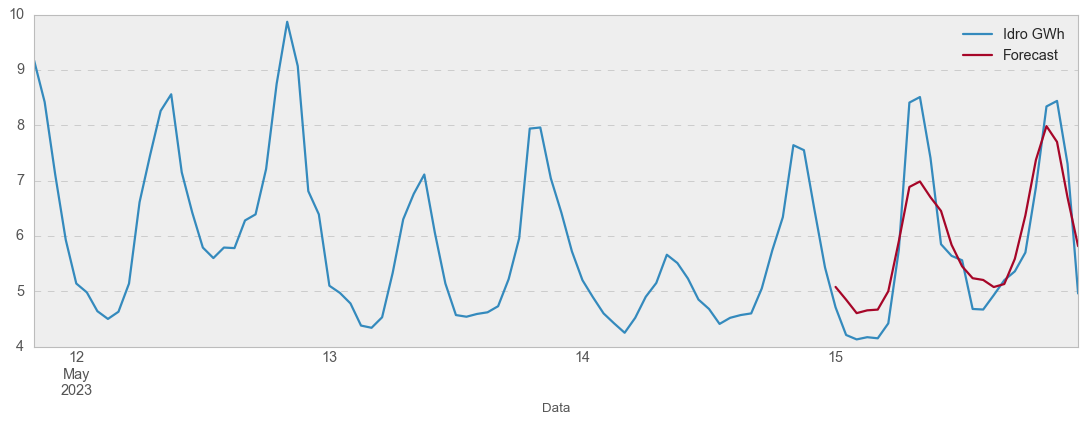

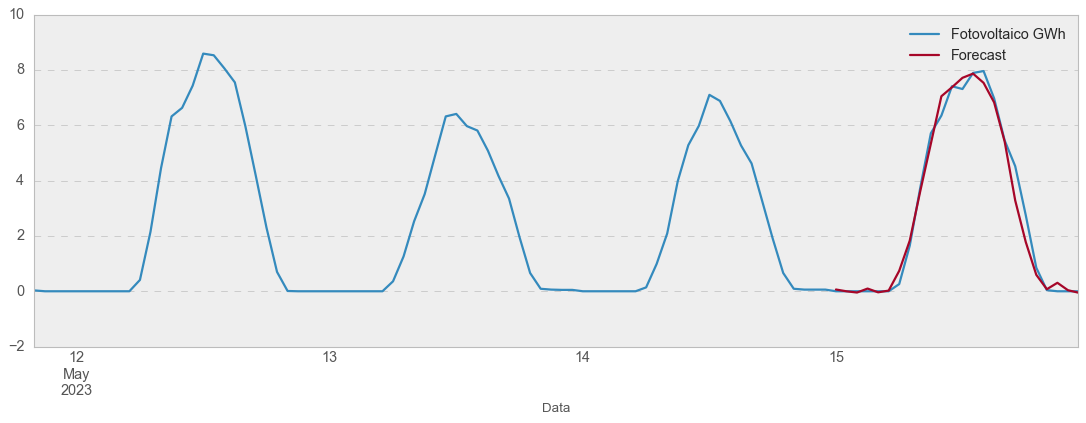

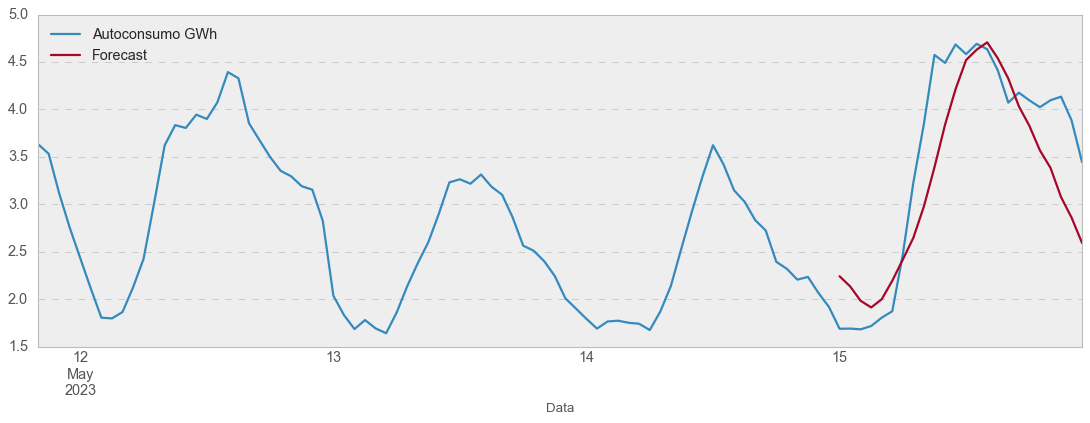

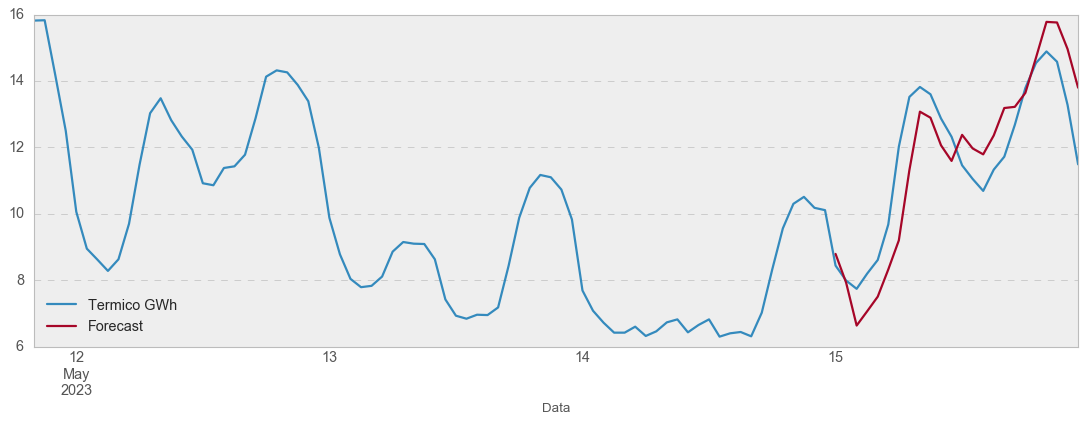

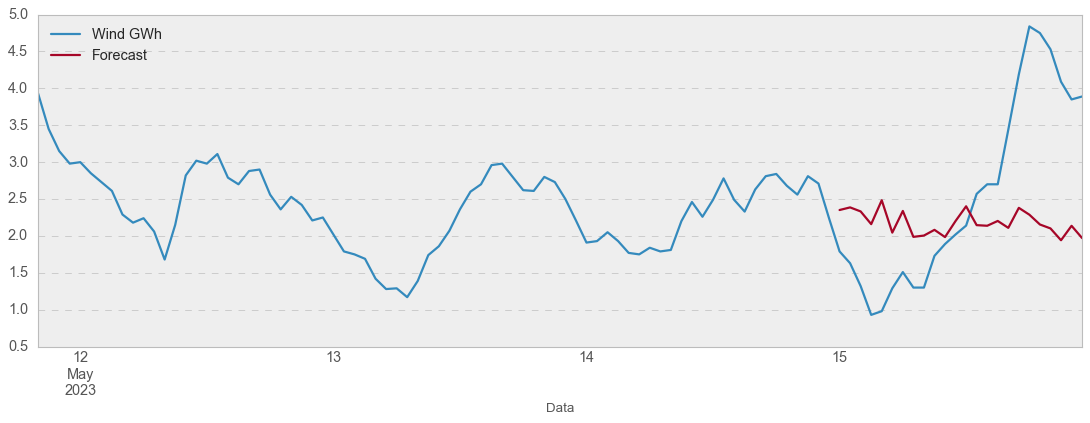

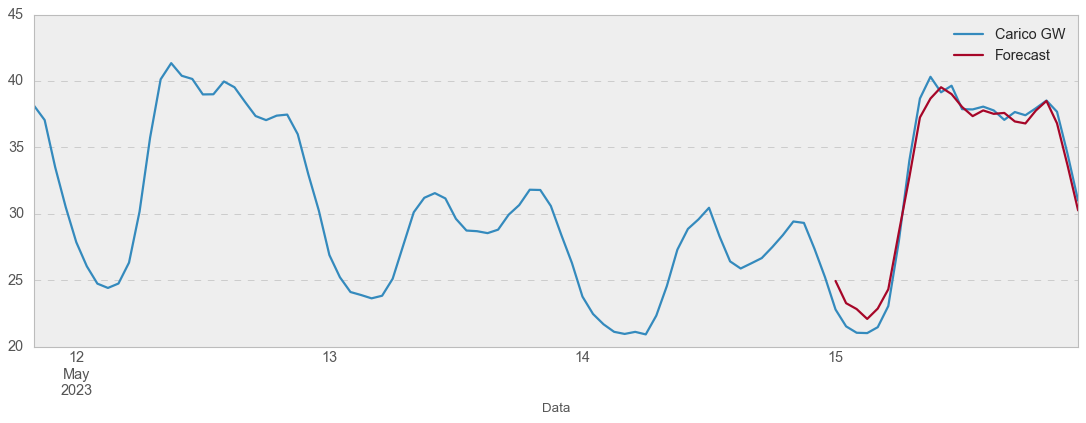

In [306]:
for source in sources:
    forecast(df1, source, 30)

The forecast is very good, especially for "Thermal" and "Load", a little less for Wind, perhaps it could improve the forecast to apply a Smoothing technique to the time series of wind itself. 
Anyway I decide to use this model to predict the two days following the last available generation and load data, of these forecasts I will use only the last one to make inference on prices. So now I reload everything so I update the dataset which I'm going to call "Storico_con_previsioni". 

In [ ]:

today = date.today()
n = 0 #NUMERO DI GIORNI IN CUI DEVI TORNARE INDIETRO

yesterday = today + timedelta(days=n)
yesterday = yesterday.strftime("%d/%m/%Y")
data_inizio = data_fine = yesterday
datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')

df_weather = pd.DataFrame()

city_num = ["16405", "16080", "16170", "16546", "16459", "16560", "16088", "16140", "16270"]
city_name = ["PA", "MI", "FI", "DECIMO", "CT", "CA", "BRE", "BO", "BA"]

giorno_inizio, mese_inizio, anno_inizio = data_inizio.split('/')
giorno_fine, mese_fine, anno_fine = data_fine.split('/')

start = datetime(int(anno_inizio), int(mese_inizio), int(giorno_inizio))

try:
    end = datetime(int(anno_fine), int(mese_fine), int(giorno_fine) + 1) # modificare in vista del cambio mese
except:
    end = datetime(int(anno_fine), int(mese_fine)+1, int('1'))

for j in range(0, 9):

    data = Hourly(city_num[j], start, end)
    data = data.fetch()
    
    data.rename(columns = {'temp' : city_name[j] + ' ' + 'temp', 'dwpt' : city_name[j] + ' ' + 'dwpt', 'rhum' : city_name[j] + ' ' + 'rhum', \
                           'prcp' : city_name[j] + ' ' + 'prcp', 'snow' : city_name[j] + ' ' + 'snow', 'wdir' : city_name[j] + ' ' + 'wdir', \
                           'wspd' : city_name[j] + ' ' + 'wspd', 'wpgt' : city_name[j] + ' ' + 'wpgt', 'pres' : city_name[j] + ' ' + 'pres', \
                          'tsun' : city_name[j] + ' ' + 'tsun', 'coco' : city_name[j] + ' ' + 'coco'}, inplace = True)

    df_weather = pd.concat([df_weather, data], axis = 1)

df_weather = df_weather.fillna(0)
df_weather = df_weather.iloc[:-1, :]
df_weather['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(df_weather), freq= "h")
df_weather = df_weather.set_index('Data')

df_storico = df1
df_storico = df_storico.set_index('Data')
df_storico = pd.concat([df_storico, df_weather], axis=0)


df5 = df_storico.iloc[:-24, :6]
df5

def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour+1
    df["dayofweek"] = df.index.dayofweek+1
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    return df
    

df5 = create_features(df5)
sources = ['Idro GWh', 'Fotovoltaico GWh', 'Autoconsumo GWh', 'Termico GWh',
       'Wind GWh', 'Carico GW']



def forecast(df, source, n_epochs):
    datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')
    
    print("____________________________________________________________________________________________\n")
    print("                                          ","\033[1;34m" + source +"\033[0m")
    print("____________________________________________________________________________________________\n")
    
    dataset_size = np.array(df).shape[0]
    n_time_step = 24 # passo temporale
    n_test = 24

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size-n_test)])
    scaler_y.fit(y[:(dataset_size-n_test)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset = np.concatenate((X, y), axis = 1)
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, dataset_size - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train, y_train = np.array(X), np.array(y)

    X = []
    y = []

    for i in range(dataset_size - n_test - n_time_step + n_time_step, dataset_size - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_test, y_test = np.array(X), np.array(y)

    print("Dim :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    Checkpoint = ModelCheckpoint(f'best_nn_model '+source+'.h5', monitor = ('val_loss'), save_best_only = True)

    imgX, imgY, imgZ = X_train.shape

    model = Sequential([

        Input(shape = (imgY, imgZ)), 
        LSTM(64, return_sequences = True),
        LSTM(32, return_sequences = True),
        Flatten(),
        Dense(126, activation = 'relu'),
        Dense(n_test)

    ])

    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse'])

    model.fit(X_train, y_train, epochs = n_epochs, callbacks = [Checkpoint], validation_data = (X_test, y_test))

    best_model = tf.keras.models.load_model(f'best_nn_model '+source+'.h5')


    y_pred = best_model.predict(X_test)

    y_pred = np.array(y_pred).reshape(-1, 1)

    inv_y_pred = scaler_y.inverse_transform(y_pred).flatten()

    train = df.iloc[:-n_test]
    test = df.iloc[-n_test:]

    train_idx = df.index <= train.index[-1]
    test_idx = df.index > train.index[-1]

    df_res = df.copy()
    df_res.loc[test_idx, 'Forecast'] = inv_y_pred

    df_res.iloc[-100:][[source, 'Forecast']].plot(figsize = (15, 5))

    print("Test R2 :", r2_score(df_res[source][-n_test:], inv_y_pred))
    print("Test MAPE :", mean_absolute_percentage_error(df_res[source][-n_test:], inv_y_pred))
    print("Test MSE :", mean_squared_error(df_res[source][-n_test:], inv_y_pred))

    forecast_horizon = n_test
    dataset_size_out_of_sample = np.array(df).shape[0] + forecast_horizon

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size_out_of_sample-forecast_horizon)])
    scaler_y.fit(y[:(dataset_size_out_of_sample-forecast_horizon)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset_out_of_sample = np.concatenate((X, y), axis = 1)

    time_series_out_of_sample = np.zeros((dataset_out_of_sample.shape[0] + forecast_horizon, dataset_out_of_sample.shape[1]))
    time_series_out_of_sample[:-forecast_horizon] = dataset_out_of_sample

    dataset = time_series_out_of_sample
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, len(time_series_out_of_sample) - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train_out_of_sample, y_train_out_of_sample = np.array(X), np.array(y)

    X = []

    for i in range(len(time_series_out_of_sample) - n_test - n_time_step + n_time_step, len(time_series_out_of_sample) - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])

    X_test_out_of_sample = np.array(X)

    print("Dim :", X_train_out_of_sample.shape, y_train_out_of_sample.shape, X_test_out_of_sample.shape)

    y_pred_out_of_sample = best_model.predict(X_test_out_of_sample)

    y_pred_out_of_sample = np.array(y_pred_out_of_sample).reshape(-1, 1)

    inv_y_pred_out_of_sample = scaler_y.inverse_transform(y_pred_out_of_sample).flatten()

    today_df = []
    today = datetime.now()

    current_time = datetime.now().strftime('%d-%m-%Y %H-%M') # per nominare i file di salvataggio

    for i in range(0, forecast_horizon):

        today_df.append(today.strftime('%Y-%m-%d'))

    df_out_of_sample = pd.DataFrame({'Data': today_df})
    df_out_of_sample['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(df_out_of_sample), freq= "h")
    df_out_of_sample = df_out_of_sample.set_index('Data')


    df_out_of_sample[source] = inv_y_pred_out_of_sample
    
    df_out_of_sample
    df_storico.update(df_out_of_sample)
    print(f"{source} previsione caricata in Storico1")
    
for source in sources:
    forecast(df5, source, 2)
    
    
    
    
    
mercati = ["MGP","MI-A1","MI-A2","MI-A3"]
for mercato in mercati:
    try:
        data_flusso = (datetime.now() + timedelta(days = n)).strftime('%Y%m%d')
        datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')

        #### MGP ####

        filename = data_flusso + f'{mercato}Prezzi.xml'

        
        ftp_server.cwd(f'/MercatiElettrici/{mercato}_Prezzi')


        ftp_server.encoding = "utf-8"

        with open(filename, "wb") as file:

            ftp_server.retrbinary(f"RETR {filename}", file.write)
        file = open(filename, "r")
        data = file.read()
        doc = xml.dom.minidom.parseString(data)
        
        if mercato == "MGP":
            cols = ["PUN","CALA", "CNOR", "CSUD", "NORD", "SARD", "SICI", "SUD"]
        else:
            cols = ["NAT","CALA", "CNOR", "CSUD", "NORD", "SARD", "SICI", "SUD"]
            
        Prezzi = pd.DataFrame()

        for j in range(0, len(cols)):

            xml_data = []
            i = 0

            for topic in doc.getElementsByTagName('Prezzi'):

                title = doc.getElementsByTagName(cols[j])[i].firstChild.nodeValue

                xml_data.append(title)

                i += 1

            Prezzi[cols[j]] = xml_data
            Prezzi[cols[j]] = np.round((Prezzi[cols[j]].replace('\.','', regex=True).replace(',','.', regex=True).astype(float)), 2)

        n_ore = Prezzi.shape[0]

        if mercato == "MI-A3":
            Prezzi['Data'] = pd.date_range(start= f"{datfl} 12:00:00", periods=len(Prezzi), freq= "h")
        else:
            Prezzi['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(Prezzi), freq= "h")
            
        Prezzi = Prezzi.set_index('Data')
        file.close()
        os.remove(filename)
        #CICLO PER CAMBIARE IL NOME ALLE COLONNE COSì DA DIFFERENZIARE I MERCATI 
        try:
            new_cols = {}
            for col in Prezzi.columns:
                new_cols[col] = col + f'_{mercato[4]}'
            Prezzi = Prezzi.rename(columns=new_cols)
        except:
            None
        


        if mercato == mercati[0]:
            df_storico.update(Prezzi)
        else:
            df_storico.update(Prezzi)
            
        print(f" {mercato} era presente nell' FTP e l'ho caricato in Storico1.xlsx")
        

    except:
        print(f" {mercato} non ancora nell' FTP")
        

### QUANTITA'###
try:    
    data_flusso = (datetime.now() + timedelta(days = n)).strftime('%Y%m%d')
    datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')
    
    filename = data_flusso + 'MGPQuantita.xml'


    ftp_server.cwd('/MercatiElettrici/MGP_Quantita')

    ftp_server.encoding = "utf-8"

    with open(filename, "wb") as file:

        ftp_server.retrbinary(f"RETR {filename}", file.write)

    file = open(filename, "r")
    data = file.read()
    doc = xml.dom.minidom.parseString(data)
    cols_name_A = ['TOTALE_ACQUISTI', 'CALA_ACQUISTI', 'CNOR_ACQUISTI', 'CSUD_ACQUISTI', 'NORD_ACQUISTI', 'SARD_ACQUISTI', 'SICI_ACQUISTI', 'SUD_ACQUISTI']

    Quantita_A = pd.DataFrame()

    for j in range(0, len(cols_name_A)):

        xml_data = []
        i = 0

        for topic in doc.getElementsByTagName('Quantita'):

            title = doc.getElementsByTagName(cols_name_A[j])[i].firstChild.nodeValue

            xml_data.append(title)

            i += 1

        Quantita_A[cols_name_A[j]] = xml_data
        Quantita_A[cols_name_A[j]] = np.round((Quantita_A[cols_name_A[j]].replace('\.','', regex=True).replace(',','.', regex=True).astype(float)), 2)

    n_ore = Quantita_A.shape[0]

    Quantita_A['Date'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(Quantita_A), freq= "h")
    Quantita_A = Quantita_A.set_index('Date')

    Quantita_A

    cols_name_V = ['TOTALE_VENDITE', 'CALA_VENDITE', 'CNOR_VENDITE', 'CSUD_VENDITE', 'NORD_VENDITE', 'SARD_VENDITE', 'SICI_VENDITE', 'SUD_VENDITE']

    Quantita_V = pd.DataFrame()

    for j in range(0, len(cols_name_V)):

        xml_data = []
        i = 0

        for topic in doc.getElementsByTagName('Quantita'):

            title = doc.getElementsByTagName(cols_name_V[j])[i].firstChild.nodeValue

            xml_data.append(title)

            i += 1

        Quantita_V[cols_name_V[j]] = xml_data
        Quantita_V[cols_name_V[j]] = np.round((Quantita_V[cols_name_V[j]].replace('\.','', regex=True).replace(',','.', regex=True).astype(float)), 2)

    Quantita_V['Date'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(Quantita_V), freq= "h")
    Quantita_V = Quantita_V.set_index('Date')

    file.close()
    os.remove(filename)

    Quantita_V

    filename = data_flusso + 'MGPLiquidita.xml'


    ftp_server.cwd('/MercatiElettrici/MGP_Liquidita')
    ftp_server.encoding = "utf-8"

    with open(filename, "wb") as file:
        ftp_server.retrbinary(f"RETR {filename}", file.write)

    file = open(filename, "r")
    data = file.read()
    doc = xml.dom.minidom.parseString(data)

    xml_data = []
    i = 0

    for topic in doc.getElementsByTagName('DatiLiquidita'):

        title = doc.getElementsByTagName('Liquidita')[i].firstChild.nodeValue

        xml_data.append(title)

        i += 1

    Liquidita = pd.DataFrame({'Liquidita' : xml_data})
    Liquidita['Liquidita'] = np.round((Liquidita['Liquidita'].replace('\.','', regex=True).replace(',','.', regex=True).astype(float)), 2)

    Liquidita['Date'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(Liquidita), freq= "h")
    Liquidita = Liquidita.set_index('Date')


    Liquidita = pd.merge(Liquidita, Quantita_A, how = 'outer', left_index = True, right_index = True)
    Liquidita = pd.merge(Liquidita, Quantita_V, how = 'outer', left_index = True, right_index = True)
    df_storico.update(Liquidita)
    
    print("Liquidità e Quantità caricate in Storico1.xlsx")
    
except:
    print("Liquidità non presente")   
    


df_storico.to_excel("STORICO\Storico1.xlsx", index = True)


### AGGIUNGE METEO, PREVEDE DOMANDA E PRODUZIONE, AGGIUNGE PREZZI DISPONIBILI 
today = date.today()
n = 1 #NUMERO DI GIORNI IN CUI DEVI ANDARE AVANTI

yesterday = today + timedelta(days=n)
yesterday = yesterday.strftime("%d/%m/%Y")
data_inizio = data_fine = yesterday
datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')

df_weather = pd.DataFrame()

city_num = ["16405", "16080", "16170", "16546", "16459", "16560", "16088", "16140", "16270"]
city_name = ["PA", "MI", "FI", "DECIMO", "CT", "CA", "BRE", "BO", "BA"]

giorno_inizio, mese_inizio, anno_inizio = data_inizio.split('/')
giorno_fine, mese_fine, anno_fine = data_fine.split('/')

start = datetime(int(anno_inizio), int(mese_inizio), int(giorno_inizio))

try:
    end = datetime(int(anno_fine), int(mese_fine), int(giorno_fine) + 1) # modificare in vista del cambio mese
except:
    end = datetime(int(anno_fine), int(mese_fine)+1, int('1'))

for j in range(0, 9):

    data = Hourly(city_num[j], start, end)
    data = data.fetch()
    
    data.rename(columns = {'temp' : city_name[j] + ' ' + 'temp', 'dwpt' : city_name[j] + ' ' + 'dwpt', 'rhum' : city_name[j] + ' ' + 'rhum', \
                           'prcp' : city_name[j] + ' ' + 'prcp', 'snow' : city_name[j] + ' ' + 'snow', 'wdir' : city_name[j] + ' ' + 'wdir', \
                           'wspd' : city_name[j] + ' ' + 'wspd', 'wpgt' : city_name[j] + ' ' + 'wpgt', 'pres' : city_name[j] + ' ' + 'pres', \
                          'tsun' : city_name[j] + ' ' + 'tsun', 'coco' : city_name[j] + ' ' + 'coco'}, inplace = True)

    df_weather = pd.concat([df_weather, data], axis = 1)

df_weather = df_weather.fillna(0)
df_weather = df_weather.iloc[:-1, :]
df_weather['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(df_weather), freq= "h")
df_weather = df_weather.set_index('Data')

df_storico = pd.read_excel(r"STORICO\Storico1.xlsx")
df_storico = df_storico.set_index('Data')
df_storico = pd.concat([df_storico, df_weather], axis=0)


df5 = df_storico.iloc[:-24, :6]
df5

def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour+1
    df["dayofweek"] = df.index.dayofweek+1
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    return df
    

df5 = create_features(df5)
sources = ['Idro GWh', 'Fotovoltaico GWh', 'Autoconsumo GWh', 'Termico GWh',
       'Wind GWh', 'Carico GW']



def forecast(df, source, n_epochs):
    datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')
    
    print("____________________________________________________________________________________________\n")
    print("                                          ","\033[1;34m" + source +"\033[0m")
    print("____________________________________________________________________________________________\n")
    
    dataset_size = np.array(df).shape[0]
    n_time_step = 24 # passo temporale
    n_test = 24

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size-n_test)])
    scaler_y.fit(y[:(dataset_size-n_test)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset = np.concatenate((X, y), axis = 1)
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, dataset_size - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train, y_train = np.array(X), np.array(y)

    X = []
    y = []

    for i in range(dataset_size - n_test - n_time_step + n_time_step, dataset_size - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_test, y_test = np.array(X), np.array(y)

    print("Dim :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    Checkpoint = ModelCheckpoint(f'best_nn_model '+source+'.h5', monitor = ('val_loss'), save_best_only = True)

    imgX, imgY, imgZ = X_train.shape

    model = Sequential([

        Input(shape = (imgY, imgZ)), 
        LSTM(64, return_sequences = True),
        LSTM(32, return_sequences = True),
        Flatten(),
        Dense(126, activation = 'relu'),
        Dense(n_test)

    ])

    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse'])

    model.fit(X_train, y_train, epochs = n_epochs, callbacks = [Checkpoint], validation_data = (X_test, y_test))

    best_model = tf.keras.models.load_model(f'best_nn_model '+source+'.h5')


    y_pred = best_model.predict(X_test)

    y_pred = np.array(y_pred).reshape(-1, 1)

    inv_y_pred = scaler_y.inverse_transform(y_pred).flatten()

    train = df.iloc[:-n_test]
    test = df.iloc[-n_test:]

    train_idx = df.index <= train.index[-1]
    test_idx = df.index > train.index[-1]

    df_res = df.copy()
    df_res.loc[test_idx, 'Forecast'] = inv_y_pred

    df_res.iloc[-100:][[source, 'Forecast']].plot(figsize = (15, 5))

    print("Test R2 :", r2_score(df_res[source][-n_test:], inv_y_pred))
    print("Test MAPE :", mean_absolute_percentage_error(df_res[source][-n_test:], inv_y_pred))
    print("Test MSE :", mean_squared_error(df_res[source][-n_test:], inv_y_pred))

    forecast_horizon = n_test
    dataset_size_out_of_sample = np.array(df).shape[0] + forecast_horizon

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size_out_of_sample-forecast_horizon)])
    scaler_y.fit(y[:(dataset_size_out_of_sample-forecast_horizon)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset_out_of_sample = np.concatenate((X, y), axis = 1)

    time_series_out_of_sample = np.zeros((dataset_out_of_sample.shape[0] + forecast_horizon, dataset_out_of_sample.shape[1]))
    time_series_out_of_sample[:-forecast_horizon] = dataset_out_of_sample

    dataset = time_series_out_of_sample
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, len(time_series_out_of_sample) - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train_out_of_sample, y_train_out_of_sample = np.array(X), np.array(y)

    X = []

    for i in range(len(time_series_out_of_sample) - n_test - n_time_step + n_time_step, len(time_series_out_of_sample) - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])

    X_test_out_of_sample = np.array(X)

    print("Dim :", X_train_out_of_sample.shape, y_train_out_of_sample.shape, X_test_out_of_sample.shape)

    y_pred_out_of_sample = best_model.predict(X_test_out_of_sample)

    y_pred_out_of_sample = np.array(y_pred_out_of_sample).reshape(-1, 1)

    inv_y_pred_out_of_sample = scaler_y.inverse_transform(y_pred_out_of_sample).flatten()

    today_df = []
    today = datetime.now()

    current_time = datetime.now().strftime('%d-%m-%Y %H-%M') # per nominare i file di salvataggio

    for i in range(0, forecast_horizon):

        today_df.append(today.strftime('%Y-%m-%d'))

    df_out_of_sample = pd.DataFrame({'Data': today_df})
    df_out_of_sample['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(df_out_of_sample), freq= "h")
    df_out_of_sample = df_out_of_sample.set_index('Data')


    df_out_of_sample[source] = inv_y_pred_out_of_sample
    
    df_out_of_sample
    df_storico.update(df_out_of_sample)
    print(f"{source} previsione caricata in Storico1")
    
for source in sources:
    forecast(df5, source, 2)
    
    
df_storico.to_excel("G:\My Drive\CODICI\Storico_con_previsioni.xlsx", index = True)

In [12]:
df = pd.read_excel(r"/Users/antonioluca/Library/CloudStorage/GoogleDrive-lucapirarba@gmail.com/Il mio Drive/CODICI/Storico_con_previsioni.xlsx")
df = df.set_index("Data")
filter_df = df[df.index.hour==0]
filter_df.tail(10)

Idro GWh  Fotovoltaico GWh  Autoconsumo GWh  Termico GWh  \
Data                                                                   
2023-06-01  1.530000          0.000000         2.284000    11.410000   
2023-06-02  1.390000          0.000000         1.687000    11.930000   
2023-06-03  1.450000          0.000000         2.738000    14.690000   
2023-06-04  1.340000          0.000000         2.907000    15.100000   
2023-06-05  4.230000          0.000000         3.083000    13.420000   
2023-06-06  6.780000          0.000000         2.878000    13.030000   
2023-06-07  6.840000          0.000000         2.473000    13.880000   
2023-06-08  7.160000          0.000000         2.501000    14.070000   
2023-06-09  5.927194         -0.221006         2.431882    13.678652   
2023-06-10  5.592720         -0.171721         2.400220    11.217602   

            Wind GWh  Carico GW  Scambio Programmato Netto Francia MW  \
Data                                                                    
2023-06-01  1.620000  24.687750                                3706.0   
2023-06-02  5.670000  25.080001                                3482.3   
2023-06-03  4.600000  25.759000                                2231.4   
2023-06-04  3.400000  29.626000                                2722.4   
2023-06-05  0.800000  28.719750                                2525.0   
2023-06-06  1.300000  28.452750                                1380.0   
2023-06-07  0.510000  28.275250                                 883.4   
2023-06-08  0.350000  28.457500                                 502.4   
2023-06-09  0.464143  28.952414                                   NaN   
2023-06-10  1.111562  30.010309                                   NaN   

            Scambio Programmato Netto Svizzera MW  \
Data                                                
2023-06-01                                 3882.0   
2023-06-02                                 1274.7   
2023-06-03                                  423.0   
2023-06-04                                 2378.0   
2023-06-05                                 1567.0   
2023-06-06                                 2293.0   
2023-06-07                                 2161.0   
2023-06-08                                 2309.0   
2023-06-09                                    NaN   
2023-06-10                                    NaN   

            Scambio Fisico Netto Francia MW  Scambio Fisico Netto Svizzera MW  \
Data                                                                            
2023-06-01                           3266.0                            3796.0   
2023-06-02                           2435.0                            2215.0   
2023-06-03                            293.0                            2314.0   
2023-06-04                           1992.0                            2860.0   
2023-06-05                           2076.0                            1644.0   
2023-06-06                           2104.0                             894.0   
2023-06-07                           1696.0                             368.0   
2023-06-08                           1924.0                             643.0   
2023-06-09                              NaN                               NaN   
2023-06-10                              NaN                               NaN   

            ...  SICI_ACQUISTI  SUD_ACQUISTI  TOTALE_VENDITE  CALA_VENDITE  \
Data        ...                                                              
2023-06-01  ...        1455.93       1613.11        22641.36       1078.37   
2023-06-02  ...        1451.82       1634.95        21134.28       1133.55   
2023-06-03  ...        1440.95       1556.06        21663.44       1198.87   
2023-06-04  ...        1432.28       1601.31        20845.70       1157.32   
2023-06-05  ...        1388.86       1616.40        19861.79        772.59   
2023-06-06  ...        1447.06       1695.43        23816.10        730.28   
2023-06-07  ...        1467.72      

In questo dataset dove per comodità visualizzo solo i giorni senza le singole ore, nelle ultime due righe, le prime 5 colonne sono rappresentate dai forecast fatti in precedenza, questi forecast ci serviranno per fare la previsione dei prezzi adesso. 


In [13]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import requests
import json
import pandas as pd
import numpy as np
import meteostat
from datetime import datetime
from time import sleep
from italian_holidays import italian_holidays
from meteostat import Point, Daily, Hourly
from meteostat import Stations
from warnings import warn
from datetime import datetime
import ftplib
import base64,xml.dom.minidom
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import os
from xml.dom.minidom import Node
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use("bmh")
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.decomposition import PCA

Exception ignored in: <function ZipFile.__del__ at 0x7f918125b280>
Traceback (most recent call last):
  File "/Users/antonioluca/opt/anaconda3/lib/python3.9/zipfile.py", line 1816, in __del__
    self.close()
  File "/Users/antonioluca/opt/anaconda3/lib/python3.9/zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
TimeoutError: [Errno 60] Operation timed out


____________________________________________________________________________________________

                                           PUN
____________________________________________________________________________________________

Dim : (10630, 24, 111) (10630, 24) (1, 24, 111) (1, 24)
Epoch 1/30
333/333 [==============================] - 10s 21ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 3/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/30
333/333 [=======================

333/333 [==============================] - 6s 18ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 4.9621e-04 - val_mse: 4.9621e-04
Epoch 24/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 3.1262e-04 - val_mse: 3.1262e-04
Epoch 25/30
333/333 [==============================] - 8s 23ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 4.1711e-04 - val_mse: 4.1711e-04
Epoch 26/30
333/333 [==============================] - 7s 20ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 6.7229e-04 - val_mse: 6.7229e-04
Epoch 27/30
333/333 [==============================] - 7s 20ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 3.1427e-04 - val_mse: 3.1427e-04
Epoch 28/30
333/333 [==============================] - 6s 19ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 1.7326e-04 - val_mse: 1.7326e-04
Epoch 29/30
333/333 [==============================] - 7s 20ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 6.5793e-04 - val_mse: 6.5793e-04
Epoch 30/30
1/1 [=

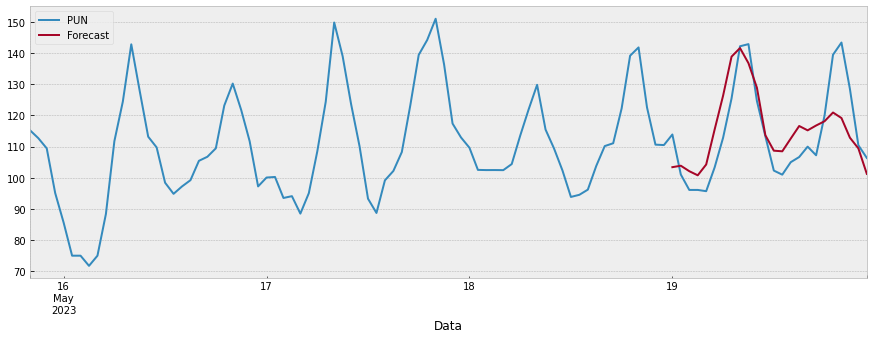

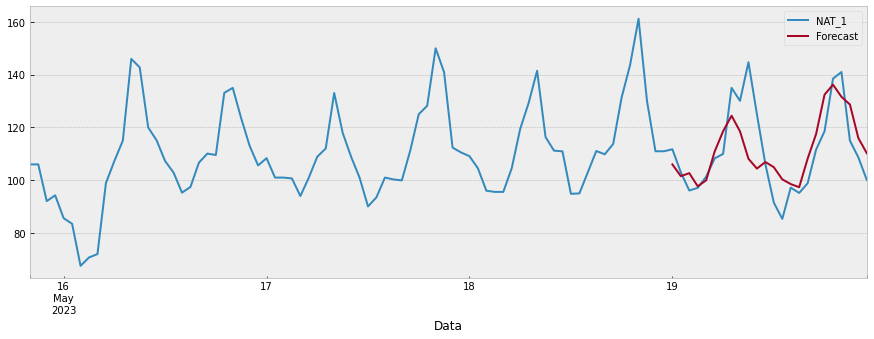

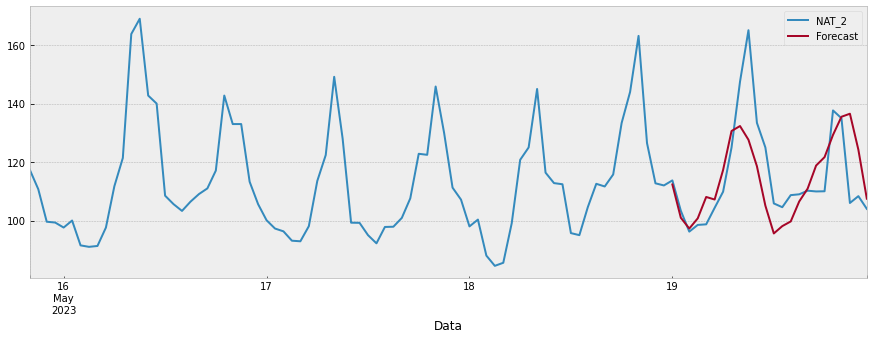

In [45]:
df_storico = pd.read_excel(r"/Users/antonioluca/Library/CloudStorage/GoogleDrive-lucapirarba@gmail.com/Il mio Drive/CODICI/Storico_con_previsioni.xlsx")
df_storico = df_storico.set_index('Data')
df_storico = df_storico.iloc[744:]
df_prezzi = pd.read_excel(r"/Users/antonioluca/Library/CloudStorage/GoogleDrive-lucapirarba@gmail.com/Il mio Drive/CODICI/Storico_con_previsioni.xlsx")
df_prezzi = df_prezzi.set_index('Data')
df_prezzi = df_prezzi.iloc[744:]

n = 1
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour+1
    df["dayofweek"] = df.index.dayofweek+1
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    return df
    

#df_prev_prezzi = create_features(df_prev_prezzi)
sources = ["PUN", "NAT_1", "NAT_2"]


def forecast(df, source, n_epochs):
    df = df_storico.iloc[:-24, :6].join(df_storico.iloc[:-24, 10:109])
    df = df.join(df_storico[source])
    df = create_features(df)

    
    datfl = (datetime.today() + timedelta(days=n)).strftime('%Y-%m-%d')
    
    print("____________________________________________________________________________________________\n")
    print("                                          ","\033[1;34m" + source +"\033[0m")
    print("____________________________________________________________________________________________\n")
    
    dataset_size = np.array(df).shape[0]
    n_time_step = 24 # passo temporale
    n_test = 24

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size-n_test)])
    scaler_y.fit(y[:(dataset_size-n_test)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset = np.concatenate((X, y), axis = 1)
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, dataset_size - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train, y_train = np.array(X), np.array(y)

    X = []
    y = []

    for i in range(dataset_size - n_test - n_time_step + n_time_step, dataset_size - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_test, y_test = np.array(X), np.array(y)

    print("Dim :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    Checkpoint = ModelCheckpoint(f'best_nn_model '+source+'.h5', monitor = ('val_loss'), save_best_only = True)

    imgX, imgY, imgZ = X_train.shape

    model = Sequential([

        Input(shape = (imgY, imgZ)), 
        LSTM(64, return_sequences = True),
        LSTM(32, return_sequences = True),
        Flatten(),
        Dense(126, activation = 'relu'),
        Dense(n_test)

    ])

    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse'])

    model.fit(X_train, y_train, epochs = n_epochs, callbacks = [Checkpoint], validation_data = (X_test, y_test))

    best_model = tf.keras.models.load_model(f'best_nn_model '+source+'.h5')


    y_pred = best_model.predict(X_test)

    y_pred = np.array(y_pred).reshape(-1, 1)

    inv_y_pred = scaler_y.inverse_transform(y_pred).flatten()

    train = df.iloc[:-n_test]
    test = df.iloc[-n_test:]

    train_idx = df.index <= train.index[-1]
    test_idx = df.index > train.index[-1]

    df_res = df.copy()
    df_res.loc[test_idx, 'Forecast'] = inv_y_pred

    df_res.iloc[-100:][[source, 'Forecast']].plot(figsize = (15, 5))

    print("Test R2 :", r2_score(df_res[source][-n_test:], inv_y_pred))
    print("Test MAPE :", mean_absolute_percentage_error(df_res[source][-n_test:], inv_y_pred))
    print("Test MSE :", mean_squared_error(df_res[source][-n_test:], inv_y_pred))

    forecast_horizon = n_test
    dataset_size_out_of_sample = np.array(df).shape[0] + forecast_horizon

    X = df[df.columns.drop(source)].to_numpy()
    y = df[source].to_numpy()

    y = y.reshape(-1, 1)

    scaler_X = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))

    scaler_X.fit(X[:(dataset_size_out_of_sample-forecast_horizon)])
    scaler_y.fit(y[:(dataset_size_out_of_sample-forecast_horizon)])
    X = scaler_X.transform(X)
    y = scaler_y.transform(y)

    dataset_out_of_sample = np.concatenate((X, y), axis = 1)

    time_series_out_of_sample = np.zeros((dataset_out_of_sample.shape[0] + forecast_horizon, dataset_out_of_sample.shape[1]))
    time_series_out_of_sample[:-forecast_horizon] = dataset_out_of_sample

    dataset = time_series_out_of_sample
    data = dataset
    target = dataset[:, -1]

    X = []
    y = []

    for i in range(0 + n_time_step, len(time_series_out_of_sample) - n_test - n_time_step):

        X.append(dataset[range(i-n_time_step, i, 1)])
        y.append(target[i:i+n_test])

    X_train_out_of_sample, y_train_out_of_sample = np.array(X), np.array(y)

    X = []

    for i in range(len(time_series_out_of_sample) - n_test - n_time_step + n_time_step, len(time_series_out_of_sample) - n_time_step + 1):

        X.append(dataset[range(i-n_time_step, i, 1)])

    X_test_out_of_sample = np.array(X)

    print("Dim :", X_train_out_of_sample.shape, y_train_out_of_sample.shape, X_test_out_of_sample.shape)

    y_pred_out_of_sample = best_model.predict(X_test_out_of_sample)

    y_pred_out_of_sample = np.array(y_pred_out_of_sample).reshape(-1, 1)

    inv_y_pred_out_of_sample = scaler_y.inverse_transform(y_pred_out_of_sample).flatten()

    today_df = []
    today = datetime.now()

    current_time = datetime.now().strftime('%d-%m-%Y %H-%M') # per nominare i file di salvataggio

    for i in range(0, forecast_horizon):

        today_df.append(today.strftime('%Y-%m-%d'))

    df_out_of_sample = pd.DataFrame({'Data': today_df})
    df_out_of_sample['Data'] = pd.date_range(start= f"{datfl} 00:00:00", periods=len(df_out_of_sample), freq= "h")
    df_out_of_sample = df_out_of_sample.set_index('Data')


    df_out_of_sample[source] = inv_y_pred_out_of_sample
    
    df_out_of_sample
    df_storico.update(df_out_of_sample)
    print(f"{source} previsione caricata in Storico1")
    
for source in sources:
    forecast(df_prezzi, source, 30)

df_storico.to_excel(r"/Users/antonioluca/Desktop/Progetto Pozzi/Storico_con_previsioni.xlsx", index = True)

The forecasts are quite good, the model manages to understand well the daily seasonality on the price trend, manages to pick up the shoulders of 7-10,19-21 hours, manages to understand that in the peak(12-17 hours) the price is very low due to the input of renewables. 

Now let's plot everything we predicted.

In [24]:
df = pd.read_excel(r"/Users/antonioluca/Library/CloudStorage/GoogleDrive-lucapirarba@gmail.com/Il mio Drive/CODICI/Storico_con_previsioni.xlsx")
df = df.set_index('Data')
selected_df = df.iloc[:, :5]

df_prod = selected_df.tail(1*24)
df_prod

Idro GWh  Fotovoltaico GWh  Autoconsumo GWh  \
Data                                                                
2023-06-12 00:00:00   7.287438         -0.027081         2.407921   
2023-06-12 01:00:00   6.820919         -0.105346         2.225157   
2023-06-12 02:00:00   6.456942         -0.142398         2.101616   
2023-06-12 03:00:00   6.404773         -0.184977         2.035084   
2023-06-12 04:00:00   6.695946         -0.228362         2.043473   
2023-06-12 05:00:00   6.835917         -0.151673         2.286786   
2023-06-12 06:00:00   7.921896          0.239128         2.668997   
2023-06-12 07:00:00   9.679833          1.142445         3.145106   
2023-06-12 08:00:00  10.673414          2.670850         3.817064   
2023-06-12 09:00:00  10.702361          4.357567         4.418829   
2023-06-12 10:00:00   9.648460          5.709243         4.936165   
2023-06-12 11:00:00   8.543794          6.621104         5.173151   
2023-06-12 12:00:00   7.436855          7.280310         5.288223   
2023-06-12 13:00:00   6.764857          7.639915         5.295250   
2023-06-12 14:00:00   6.550108          7.600763         5.138078   
2023-06-12 15:00:00   6.531219          6.991867         4.930010   
2023-06-12 16:00:00   6.620976          6.004866         4.663383   
2023-06-12 17:00:00   6.917007          4.672516         4.354717   
2023-06-12 18:00:00   7.905262          3.049218         4.130154   
2023-06-12 19:00:00   8.778336          1.519202         3.986717   
2023-06-12 20:00:00   9.674465          0.540182         3.849694   
2023-06-12 21:00:00   9.714334          0.196002         3.679661   
2023-06-12 22:00:00   9.235553          0.099100         3.445410   
2023-06-12 23:00:00   8.369151          0.019609         3.219890   

                     Termico GWh  Wind GWh  
Data                                        
2023-06-12 00:00:00    10.098988  1.329480  
2023-06-12 01:00:00     9.690218  1.495959  
2023-06-12 02:00:00     9.163321  1.526261  
2023-06-12 03:00:00     8.777259  1.295823  
2023-06-12 04:00:00     8.577662  1.374461  
2023-06-12 05:00:00     9.315427  1.463588  
2023-06-12 06:00:00    10.284312  1.420317  
2023-06-12 07:00:00    11.527636  1.378702  
2023-06-12 08:00:00    12.295962  1.457753  
2023-06-12 09:00:00    12.267597  1.469692  
2023-06-12 10:00:00    12.117266  1.670290  
2023-06-12 11:00:00    11.926394  1.595363  
2023-06-12 12:00:00    11.599946  1.594528  
2023-06-12 13:00:00    11.210030  1.586055  
2023-06-12 14:00:00    11.331518  1.658374  
2023-06-12 15:00:00    11.855109  1.887461  
2023-06-12 16:00:00    12.460593  1.681285  
2023-06-12 17:00:00    12.706940  1.555131  
2023-06-12 18:00:00    12.989716  1.711015  
2023-06-12 19:00:00    13.268671  1.741293  
2023-06-12 20:00:00    14.094022  1.724421  
2023-06-12 21:00:00    14.015218  1.511450  
2023-06-12 22:00:00    13.321606  1.683578  
2023-06-12 23:00:00    12.502256  1.470155

In [15]:
import plotly.graph_objects as go
import plotly.io as pio

colors = ['#FF4136', '#FF851B', '#FFDC00', 
          '#2ECC40', '#0074D9', '#B10DC9', 
          '#85144b', '#F012BE', '#39CCCC', 
          '#3D9970']

# Set the dark theme
pio.templates.default = "plotly_white"
stackgroup = "group1"
# Stacked Area Plot
fig = go.Figure()
for column, color in zip(df_prod.columns, colors):
    fig.add_trace(go.Scatter(x=df_prod.index, y=df_prod[column],
                             mode='lines', stackgroup=stackgroup, name=column,
                             fill='tonexty', line=dict(color=color)))
fig.update_layout(xaxis=dict(title='Date'), yaxis=dict(title='Energy (GWh)'),
                     title={
        'text': 'Power Generation PREDICTED VALUES',
        'x': 0.5,
        'y': 0.9
    })
fig.show()


fig = go.Figure()
# Pie chart
fig.add_trace(go.Pie(labels=df_prod.index, values=df_prod.values))


fig = go.Figure()
fig.add_trace(go.Pie(
    labels=df_prod.sum().index,
    values=df_prod.sum().values,
    marker=dict(colors=colors),
    hoverinfo='label+value',
    textfont=dict(size=12),
    hole=0.72,
    sort=False
))

# Update the layout
fig.update_layout(
    title={
        'text': 'Power Generation Piechart PREDICTED VALUES ',
        'x': 0.5,
        'y': 0.9
    }
)


# Show the plot
fig.show()

![Example Image](newplot-9.png)
![Example Image](newplot-10.png)

In [25]:
dfpun = df["PUN"].tail(24)
dfmi1 = df["NAT_1"].tail(24)
dfmi2 = df["NAT_2"].tail(24)
dfmi3 = df["NAT_3"].tail(24)
# Create the scatter line plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfpun.index, y=dfpun, mode='lines', name="PUN"))
fig.add_trace(go.Scatter(x=dfmi1.index, y=dfmi1, mode='lines', name="MI1"))
fig.add_trace(go.Scatter(x=dfmi2.index, y=dfmi2, mode='lines', name="MI2"))
#fig.add_trace(go.Scatter(x=dfmi3.index, y=dfmi3, mode='lines', name="MI3"))

fig.update_layout(
    title='Italian power prices PREDICTED VALUES',
    xaxis=dict(title='Date'),
    yaxis=dict(title='€/MWh'))
fig.show()

![Example Image](newplot-12.png)

## FUTURE DEVELOPMENTS OF THIS WORK

With these results, the next step will be:
Use a model that takes as input not values from the dataset but images, an image consisting of 24 X 100 pixels where 24 will be the hours to be predicted (the sliding window, the time step) while 100 will be the input features of the model, each quinid value will be converted into a pixel that will have an asssumed color between black and white depending on the value itself. 

Through a Convolutional Neural Network, normally used for analysis and detenction images one could try to predict prices, checking then the predictions could be compared with those obtained with the simple LSTM.